# Comparing Error of Calibrated vs. Non-Calibrated Models

In [2]:
# ruff: noqa: E402
%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl


ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))

### Make a Color Function for Plotting

In [3]:
engine_color = [0.65, 0.65, 0.65]
gps_color = [0, 0, 0.75]
plutron_color = [0, 0, 0]
alabama = [165, 30, 54]
alabama = [i / 255 for i in alabama]


def get_color(model_pretty: str) -> list:
    if "Krauss" in model_pretty:
        return alabama
    elif "W99" in model_pretty:
        return gps_color
    elif "IDM" in model_pretty:
        return engine_color
    else:
        return [0, 0, 0]


def get_linestyle(model_pretty: str) -> str:
    if "Calibrated - Accel" in model_pretty:
        return "-"
    elif "Calibrated" in model_pretty:
        return "--"
    elif "Default" in model_pretty:
        return ":"
    else:
        return "-"


def get_label(model_pretty: str) -> str:
    if "Calibrated - Accel" in model_pretty:
        return "$\\text{NRMSE}(s, v, a)$"
    elif "Calibrated" in model_pretty:
        return "$\\text{NRMSE}(s, v)$"
    elif "Default" in model_pretty:
        return "Default"
    elif "Real World" in model_pretty:
        return "Observed"

    else:
        return model_pretty

## Define Experiment Directories

In [4]:
# fps = {
#     "Krauss - Default": ROOT / "tmp" / "KraussDefault" / "02.12.2024_11.26.09",
#     "Krauss - Calibrated": ROOT / "tmp/KraussCalibration/02.13.2024_20.56.57",
#     "W99 - Default": ROOT / "tmp/W99Default/02.12.2024_10.57.41",
#     "W99 - Calibrated": ROOT / "tmp/W99Calibration/02.13.2024_20.12.32",
#     "IDM - Default": ROOT / "tmp/IDMCarFollowingDefault/02.12.2024_10.16.02",
#     "IDM - Calibrated": ROOT / "tmp/IDMCalibration/02.13.2024_19.40.56",
# }
fps = {
    "Krauss - Default": ROOT / "tmp/KraussDefault/02.15.2024_21.06.45",
    "Krauss - Calibrated - Accel": ROOT / "tmp/KraussCalibration/02.15.2024_21.39.26",
    "Krauss - Calibrated": ROOT / "tmp/KraussCalibration/02.16.2024_09.45.15",
    "W99 - Default": ROOT / "tmp/W99Default/02.15.2024_21.06.12",
    "W99 - Calibrated - Accel": ROOT / "tmp/W99Calibration/02.15.2024_21.20.19",
    "W99 - Calibrated": ROOT / "tmp/W99Calibration/02.16.2024_09.26.45",
    "IDM - Default": ROOT / "tmp/IDMCarFollowingDefault/02.15.2024_21.05.39",
    "IDM - Calibrated": ROOT / "tmp/IDMCalibration/02.16.2024_09.16.21",
    "IDM - Calibrated - Accel": ROOT / "tmp/IDMCalibration/02.15.2024_21.07.17",
    # "IDM - Calibrated - 1 sec": ROOT / "tmp/IDMCalibration1Sec/02.17.2024_13.15.51",
}

## Load the Results

In [5]:
res_df = pl.concat(
    [
        pl.scan_parquet(str(fp / "results.parquet"))
        .with_columns(model_pretty=pl.lit(name))
        .pipe(
            lambda df: df.with_columns(
                pl.lit(0, dtype=float).alias("opt_time")
                if "opt_time" not in df.columns
                else pl.col("opt_time")
            )
        )
        .select(
            [
                "model_pretty",
                pl.col("run_id").cast(int),
                "follower_id",
                "leader_id",
                pl.col("^nrmse_.*$"),
                pl.col("^rmse_.*$"),
                "collision",
                "cf_model",
                "opt_time",
            ]
        )
        for name, fp in fps.items()
    ]
).collect()

In [6]:
res_df.filter(
    ~pl.col("model_pretty").str.contains("Default") & ~pl.col("collision")
).select(
    pl.col("opt_time").mean(),
    pl.col("opt_time").std().alias("std"),
    pl.col("opt_time").median().alias("median"),
)

shape: (1, 3)
┌───────────┬───────────┬───────────┐
│ opt_time  ┆ std       ┆ median    │
│ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╡
│ 44.820024 ┆ 40.645064 ┆ 30.768433 │
└───────────┴───────────┴───────────┘

In [7]:
res_df.filter(
    ~pl.col("model_pretty").str.contains("Default") & ~pl.col("collision")
).group_by(
    [
        "model_pretty",
    ]
).agg(
    pl.col("opt_time").mean(),
    pl.col("opt_time").std().alias("std"),
    pl.col("opt_time").median().alias("median"),
).to_pandas()

model_pretty   opt_time        std     median
0     IDM - Calibrated - Accel  36.616421  28.677072  30.070570
1     W99 - Calibrated - Accel  54.254835  46.059441  36.653720
2  Krauss - Calibrated - Accel  49.065762  47.235101  29.048438
3          Krauss - Calibrated  47.790565  46.956446  27.827578
4             W99 - Calibrated  52.213830  43.977821  35.416303
5             IDM - Calibrated  29.051012  11.248686  27.427764

In [8]:
res_df.group_by("model_pretty").agg(pl.col("collision").sum())

shape: (9, 2)
┌─────────────────────────────┬───────────┐
│ model_pretty                ┆ collision │
│ ---                         ┆ ---       │
│ str                         ┆ u32       │
╞═════════════════════════════╪═══════════╡
│ IDM - Default               ┆ 3         │
│ Krauss - Calibrated - Accel ┆ 25        │
│ W99 - Calibrated            ┆ 1         │
│ Krauss - Default            ┆ 762       │
│ W99 - Default               ┆ 81        │
│ Krauss - Calibrated         ┆ 25        │
│ IDM - Calibrated - Accel    ┆ 1         │
│ IDM - Calibrated            ┆ 1         │
│ W99 - Calibrated - Accel    ┆ 1         │
└─────────────────────────────┴───────────┘

In [9]:
failed_runs = res_df.filter(pl.col("collision"))['run_id'].unique()

In [10]:
best_model_count = (
    res_df.filter(~pl.col("run_id").is_in(failed_runs))
    .group_by("run_id")
    .agg(pl.col("model_pretty").sort_by(pl.col("nrmse_s_v_a")).first())["model_pretty"]
    .value_counts()
    .to_pandas()
    .sort_values("count")
    .set_index("model_pretty")
)

In [11]:
best_model_count

count
model_pretty                      
IDM - Default                   11
W99 - Calibrated                17
W99 - Default                   18
Krauss - Calibrated             49
W99 - Calibrated - Accel        77
Krauss - Calibrated - Accel    141
IDM - Calibrated               346
IDM - Calibrated - Accel       973

In [12]:
import pandas as pd

crash_count = res_df.group_by("model_pretty").agg(pl.col("collision").sum())

non_failed_runs = res_df.filter(~pl.col("run_id").is_in(failed_runs))

correlation_data = []
for m in non_failed_runs["model_pretty"].unique():

    model_df = (
        non_failed_runs.filter((pl.col("model_pretty") == m))
        # .sort(["run_id", "time_sim"])
        # .group_by(["run_id", "model_pretty"])
        # .agg(
        #     pl.col("energy_real_kWh").last().alias("energy_real_kWh"),
        #     pl.col("energy_sim_kWh").last().alias("energy_sim_kWh"),
        # )
        # # .select("accel_follow")
        # .to_pandas()[["energy_real_kWh", "energy_sim_kWh"]]
    )
    # add the results to the dataframe
    # df = df.append({'Model': m, 'R2 Score': r2, 'Pearson R': pearson_r, }, ignore_index=True)

    correlation_data.append(
        {
            "Model": (m.split(" - ")[0], get_label(m)),
            # ("Model Evaluation", "Pearson r"): pearson_r,
            # ("RMSE(s)", "Mean"): model_df["rmse_s"].mean(),
            ("RMSE(s)", "$P_{50\%}$"): model_df["rmse_s"].quantile(0.5),
            ("RMSE(s)", "$P_{95\%}$"): model_df["rmse_s"].quantile(0.95),
            # ("RMSE(v)", "Mean"): model_df["rmse_velocity"].mean(),
            ("RMSE(v)", "$P_{50\%}$"): model_df["rmse_velocity"].quantile(0.5),
            ("RMSE(v)", "$P_{95\%}$"): model_df["rmse_velocity"].quantile(0.95),
            # ("RMSE(a)", "Mean"): model_df["rmse_accel"].mean(),
            ("RMSE(a)", "$P_{50\%}$"): model_df["rmse_accel"].quantile(0.5),
            ("RMSE(a)", "$P_{95\%}$"): model_df["rmse_accel"].quantile(0.95),
            ("Vehicle", "Collisions"): crash_count.filter(pl.col("model_pretty") == m)[
                "collision"
            ][0],
            ("Vehicle", "Best Model"): best_model_count.loc[m]["count"] if m in best_model_count.index else 0,
            # ("Summary Statistics", "$P_{50\%}$"): np.percentile(sim_energy, 50),
            # ("Summary Statistics", "$P_{90\%}$"): np.percentile(sim_energy, 90),
            # ("Summary Statistics", "$P_{99\%}$"): np.percentile(sim_energy, 99),
            # ("Summary Statistics", "Total"): np.sum(sim_energy),
        }
    )


# #  add a row for the real world data
# correlation_data.append(
#     {
#         "Model": ("Real World", "Observed"),
#         # ("Model Evaluation", "Pearson r"): None,
#         ("Model Evaluation", "$R^2$"): None,
#         ("Model Evaluation", "RMSE"): None,
#         ("Summary Statistics", "$P_{50\%}$"): np.percentile(real_energy, 50),
#         ("Summary Statistics", "$P_{90\%}$"): np.percentile(real_energy, 90),
#         ("Summary Statistics", "$P_{99\%}$"): np.percentile(real_energy, 99),
#         ("Summary Statistics", "Total"): np.sum(real_energy),
#     }
# )


correlation_df = pd.DataFrame(correlation_data)
correlation_df = correlation_df.set_index(
    pd.MultiIndex.from_tuples(correlation_df["Model"], names=["Model", "Model Label"])
).drop("Model", axis=1)

# make the columns a multiindex
correlation_df.columns = pd.MultiIndex.from_tuples(correlation_df.columns)

correlation_df = correlation_df.sort_index().sort_index(axis=1)
correlation_df.head(20).round(2)

RMSE(a)               RMSE(s)             \
                               $P_{50\%}$ $P_{95\%}$ $P_{50\%}$ $P_{95\%}$   
Model  Model Label                                                           
IDM    $\text{NRMSE}(s, v)$          0.53       1.21       2.14       7.94   
       $\text{NRMSE}(s, v, a)$       0.47       0.99       2.60       8.74   
       Default                       0.69       1.35      10.21      42.00   
Krauss $\text{NRMSE}(s, v)$          0.79       1.54       2.97      10.74   
       $\text{NRMSE}(s, v, a)$       0.55       1.03       3.98      15.95   
       Default                       0.85       1.65      11.04      44.95   
W99    $\text{NRMSE}(s, v)$          1.29       2.40       3.07      11.11   
       $\text{NRMSE}(s, v, a)$       0.63       1.11       5.23      16.50   
       Default                       0.66       1.25       8.38      39.50   

                                  RMSE(v)               Vehicle             
                               $P_{50\%}$ $P_{95\%}$ Best Model Collisions  
Model  Model Label                                                          
IDM    $\text{NRMSE}(s, v)$          0.79       1.93        346          1  
       $\text{NRMSE}(s, v, a)$       0.78       1.97        973          1  
       Default                       1.61       4.56         11          3  
Krauss $\text{NRMSE}(s, v)$          0.97       2.32         49         25  
       $\text{NRMSE}(s, v, a)$       0.99       2.39        141         25  
       Default                       1.78       5.03          0        762  
W99    $\text{NRMSE}(s, v)$          1.13       2.40         17          1  
       $\text{NRMSE}(s, v, a)$       1.13       2.68         77          1  
       Default                       1.36       4.06         18         81

In [13]:
# make it latex, round to 3 decimal places
def highlight_min( col):
    def _highlight_min(s):
        if s == correlation_df[col].min():
            return  "\\textbf{" + str(round(s, 2)) + "}"
        # elif s is the second lowest, underline it
        elif s == correlation_df[col].sort_values().iloc[1]:
            return  "\\underline{" + str(round(s, 2)) + "}"
        else:
            return str(round(s, 2))

    return _highlight_min
    



print(
    correlation_df.to_latex(
        caption="Model evaluation metrics for the energy consumption of the calibrated car following models.",
        label="tab:energy-model-eval",
        # bold the min
        formatters={
            **{
                k: highlight_min(k)
                for k in correlation_df.columns
                if k
                not in [
                    ("Vehicle", "Best Model"),
                    # ("Model Evaluation", "$R^2$"),
                    # ("Model Evaluation", "Pearson r"),
                ]
            }
        },
    )
)

\begin{table}
\caption{Model evaluation metrics for the energy consumption of the calibrated car following models.}
\label{tab:energy-model-eval}
\begin{tabular}{llrrrrrrrr}
\toprule
 &  & \multicolumn{2}{r}{RMSE(a)} & \multicolumn{2}{r}{RMSE(s)} & \multicolumn{2}{r}{RMSE(v)} & \multicolumn{2}{r}{Vehicle} \\
 &  & $P_{50\%}$ & $P_{95\%}$ & $P_{50\%}$ & $P_{95\%}$ & $P_{50\%}$ & $P_{95\%}$ & Best Model & Collisions \\
Model & Model Label &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{IDM} & $\text{NRMSE}(s, v)$ & \underline{0.53} & 1.21 & \textbf{2.14} & \textbf{7.94} & \underline{0.79} & \textbf{1.93} & 346 & \textbf{1} \\
 & $\text{NRMSE}(s, v, a)$ & \textbf{0.47} & \textbf{0.99} & \underline{2.6} & \underline{8.74} & \textbf{0.78} & \underline{1.97} & 973 & \textbf{1} \\
 & Default & 0.69 & 1.35 & 10.21 & 42.0 & 1.61 & 4.56 & 11 & 3 \\
\cline{1-10}
\multirow[t]{3}{*}{Krauss} & $\text{NRMSE}(s, v)$ & 0.79 & 1.54 & 2.97 & 10.74 & 0.97 & 2.32 & 49 & 25 \\
 & $\text{NRMSE}(s, v, 

In [14]:
res_df.filter(~pl.col("run_id").is_in(failed_runs)).groupby("run_id").agg(
    pl.col("model_pretty").sort_by(pl.col("nrmse_s_v_a")).first()
)["model_pretty"].value_counts().to_pandas().sort_values("count").assign(
    percentage=lambda df: df["count"] / df["count"].sum()
)

/tmp/ipykernel_73745/2644368344.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  res_df.filter(~pl.col("run_id").is_in(failed_runs)).groupby("run_id").agg(


model_pretty  count  percentage
7                IDM - Default     11    0.006740
4             W99 - Calibrated     17    0.010417
5                W99 - Default     18    0.011029
1          Krauss - Calibrated     49    0.030025
0     W99 - Calibrated - Accel     77    0.047181
6  Krauss - Calibrated - Accel    141    0.086397
2             IDM - Calibrated    346    0.212010
3     IDM - Calibrated - Accel    973    0.596201

### Look at Error Metrics

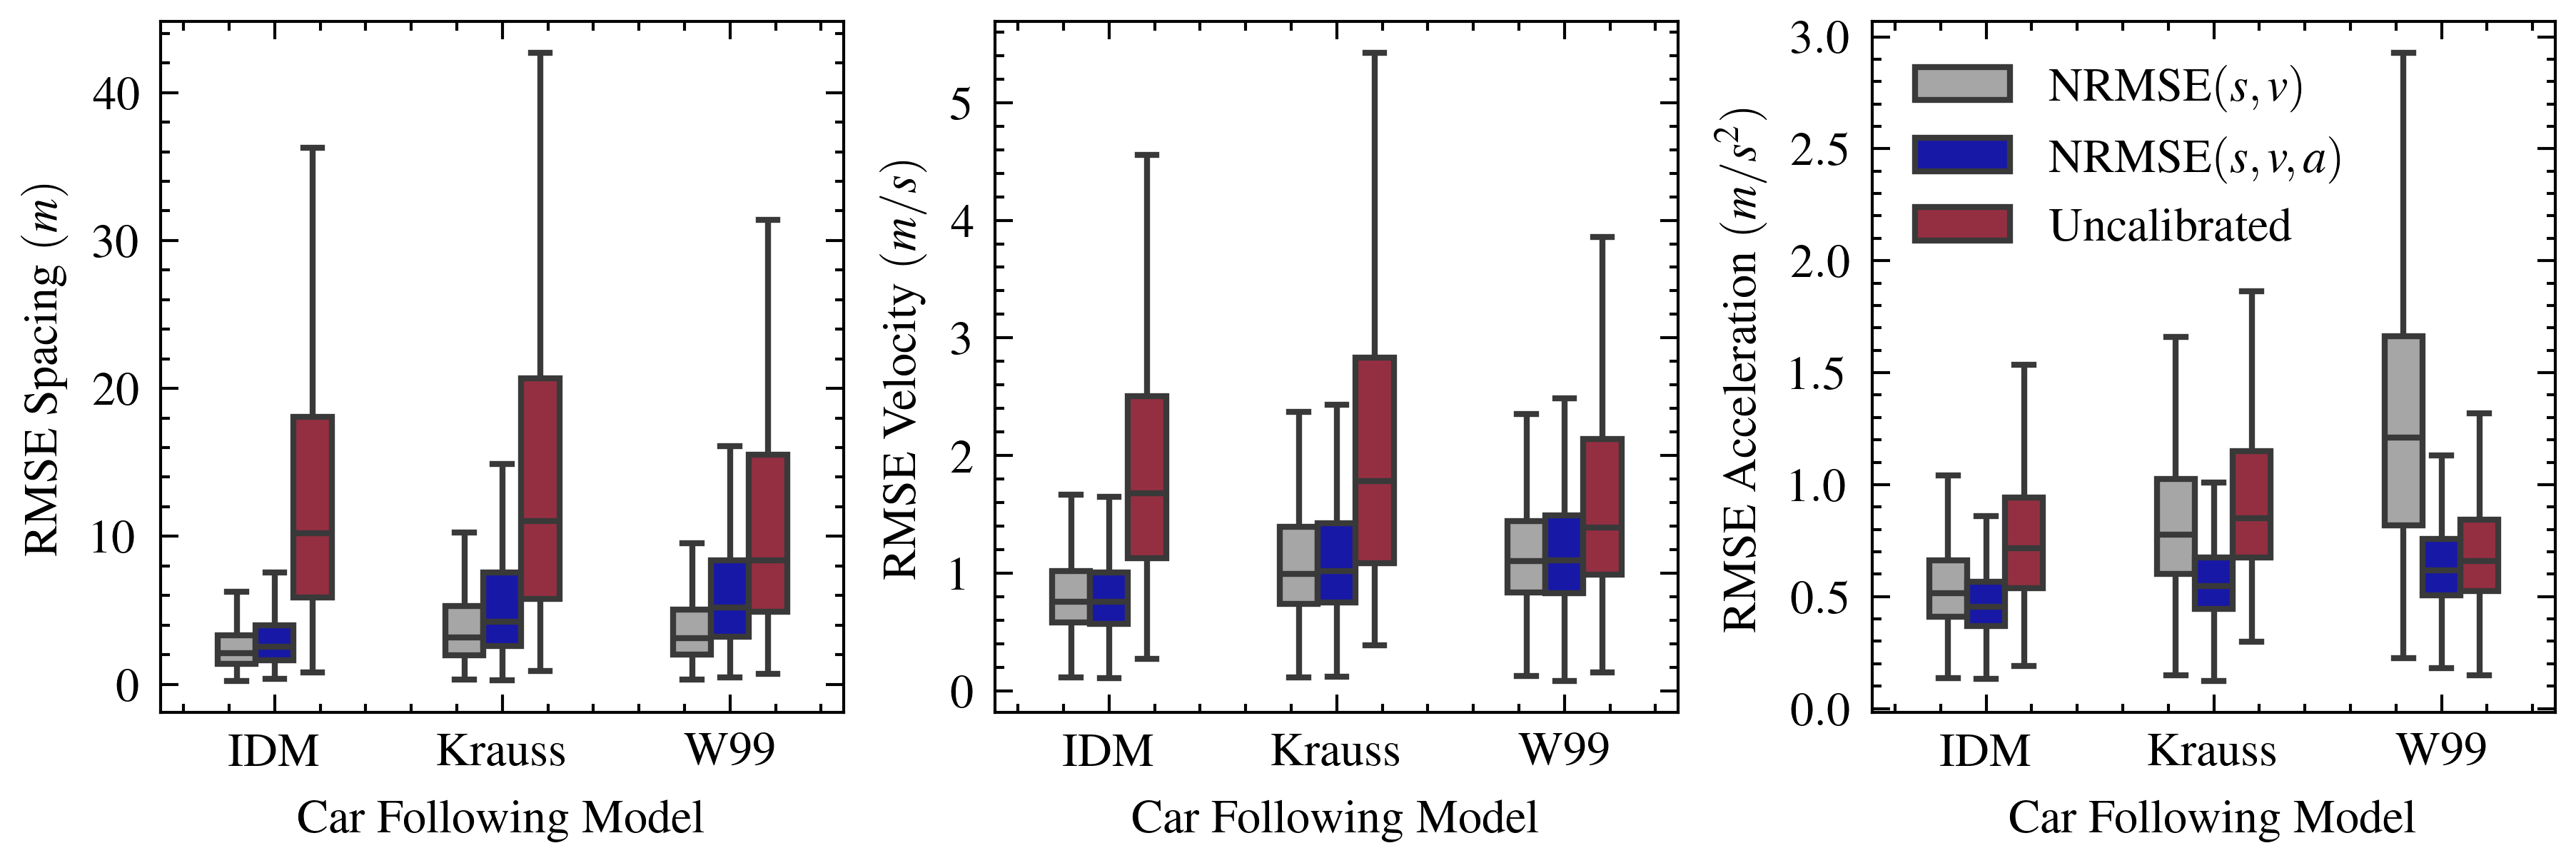

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "ieee"])


# convert all the colors to the range [0, 1]

fig, ax = plt.subplots(
    1,
    3,
    figsize=(6, 2),
    constrained_layout=True,
)

res_df = res_df.sort("model_pretty")

sns.boxplot(
    data=res_df.filter(~pl.col("collision"))
    .with_columns(
        pl.col("model_pretty")
        .str.split(" - ")
        .list.get(-1)
        .replace(
            {
                "Default": "Uncalibrated",
                "Calibrated": "$\\text{NRMSE}(s, v)$",
                "Accel": "$\\text{NRMSE}(s, v, a)$",
                "1 sec": "1 sec",
            }
        )
    )
    .to_pandas(),
    x="cf_model",
    y="rmse_s",
    ax=ax[0],
    hue="model_pretty",
    width=0.5,
    # don't show the outliers
    showfliers=False,
    palette=[engine_color, gps_color, alabama],
)

sns.boxplot(
    data=res_df.filter(~pl.col("collision"))
    .with_columns(
        pl.col("model_pretty")
        .str.split(" - ")
        .list.get(-1)
        .replace(
            {
                "Default": "Uncalibrated",
                "Calibrated": "$\\text{NRMSE}(s, v)$",
                "Accel": "$\\text{NRMSE}(s, v, a)$",
            }
        )
    )
    .to_pandas(),
    x="cf_model",
    y="rmse_velocity",
    ax=ax[1],
    hue="model_pretty",
    width=0.5,
    # don't show the outliers
    showfliers=False,
    palette=[engine_color, gps_color, alabama],
)


sns.boxplot(
    data=res_df.filter(~pl.col("collision"))
    .with_columns(
        pl.col("model_pretty")
        .str.split(" - ")
        .list.get(-1)
        .replace(
            {
                "Default": "Uncalibrated",
                "Calibrated": "$\\text{NRMSE}(s, v)$",
                "Accel": "$\\text{NRMSE}(s, v, a)$",
            }
        )
    )
    .to_pandas(),
    x="cf_model",
    y="rmse_accel",
    ax=ax[2],
    hue="model_pretty",
    width=0.5,
    # don't show the outliers
    showfliers=False,
    palette=[engine_color, gps_color, alabama],
)


ax[0].set_xlabel("Car Following Model")
ax[1].set_xlabel("Car Following Model")
ax[2].set_xlabel("Car Following Model")
ax[0].set_ylabel("RMSE Spacing $(m)$")
ax[1].set_ylabel("RMSE Velocity $(m/s)$")
ax[2].set_ylabel("RMSE Acceleration $(m/s^2)$")

plt.legend(
    title="",
)
# turn the legend off for the second plot
ax[0].get_legend().remove()
ax[1].get_legend().remove()

# plt.tight_layout()
plt.show()

In [16]:
from scipy.stats import kruskal

kruskal(
    *res_df.filter(~pl.col("collision"))
    .group_by("model_pretty")
    .agg(pl.col("rmse_s"))["rmse_s"]
    .to_list()
)

KruskalResult(statistic=7067.409347742284, pvalue=0.0)

In [17]:
# res_df.filter(~pl.col("collision")).group_by("model_pretty").agg(pl.col("rmse_s"))['rmse_s'].to_list()

In [18]:
(
    res_df.filter(~pl.col("collision"))
    .group_by("model_pretty")
    .agg(
        pl.col("rmse_s").mean(),
        pl.col("rmse_velocity").mean(),
        pl.col("rmse_accel").mean(),
    )
    .with_columns(
        pl.col("*").rank().name.suffix("_rank"),
    )
    .to_pandas()
    .sort_values("rmse_accel")
)

model_pretty     rmse_s  rmse_velocity  rmse_accel  \
3     IDM - Calibrated - Accel   3.730023       0.926265    0.504072   
2             IDM - Calibrated   3.192624       0.937339    0.582876   
1  Krauss - Calibrated - Accel   6.426470       1.219579    0.590771   
5     W99 - Calibrated - Accel   6.997486       1.307852    0.657527   
7                W99 - Default  13.107257       1.801211    0.717392   
8                IDM - Default  14.740652       2.046831    0.776186   
0          Krauss - Calibrated   4.767693       1.181136    0.852233   
4             Krauss - Default  16.029535       2.231256    0.953456   
6             W99 - Calibrated   4.607614       1.276859    1.292657   

   model_pretty_rank  rmse_s_rank  rmse_velocity_rank  rmse_accel_rank  
3                2.0          2.0                 1.0              1.0  
2                1.0          1.0                 2.0              2.0  
1                5.0          5.0                 4.0              3.0  
5                8.0          6.0                 6.0              4.0  
7                9.0          7.0                 7.0              5.0  
8                3.0          8.0                 8.0              6.0  
0                4.0          4.0                 3.0              7.0  
4                6.0          9.0                 9.0              8.0  
6                7.0          3.0                 5.0              9.0

In [19]:
from scikit_posthocs import posthoc_mannwhitney, posthoc_conover
from scikit_posthocs import critical_difference_diagram


test = posthoc_conover(
    res_df.filter(
        ~pl.col("collision") & pl.col("model_pretty").str.contains("Default")
    ).to_pandas(),
    val_col="rmse_s",
    group_col="model_pretty",
    # alternative="two-sided",
)


# # get the rank
# critical_difference_diagram(
#     ranks=res_df.filter(~pl.col("collision"))
#     .group_by("model_pretty")
#     .agg(pl.col("rmse_s").mean())
#     .with_columns(pl.col("rmse_s").rank().alias("ranks"))
#     .sort("model_pretty")
#     .to_pandas().set_index('model_pretty')["ranks"],
#     sig_matrix=test,
# )

In [20]:
test.round(3)

IDM - Default  Krauss - Default  W99 - Default
IDM - Default             1.000             0.048            0.0
Krauss - Default          0.048             1.000            0.0
W99 - Default             0.000             0.000            1.0

In [21]:
res_df.filter(
    ~pl.col("collision") & pl.col("model_pretty").str.contains("Default")
).to_pandas().groupby("model_pretty")["rmse_s"].describe().round(2)

count   mean    std   min   25%    50%    75%     max
model_pretty                                                            
IDM - Default     2394.0  14.74  15.34  0.80  5.89  10.22  18.09  194.30
Krauss - Default  1635.0  16.03  16.31  0.90  5.79  11.05  20.69  192.66
W99 - Default     2316.0  13.11  15.33  0.69  4.92   8.37  15.51  192.88

In [22]:
test = posthoc_conover(
    res_df.filter(
        ~pl.col("collision") & ~pl.col("model_pretty").str.contains("Default")
    ).to_pandas(),
    val_col="rmse_s",
    group_col="model_pretty",
    p_adjust="holm",
    # alternative="two-sided",
)

In [23]:
test.round(3)

IDM - Calibrated  IDM - Calibrated - Accel  \
IDM - Calibrated                          1.0                       0.0   
IDM - Calibrated - Accel                  0.0                       1.0   
Krauss - Calibrated                       0.0                       0.0   
Krauss - Calibrated - Accel               0.0                       0.0   
W99 - Calibrated                          0.0                       0.0   
W99 - Calibrated - Accel                  0.0                       0.0   

                             Krauss - Calibrated  Krauss - Calibrated - Accel  \
IDM - Calibrated                           0.000                          0.0   
IDM - Calibrated - Accel                   0.000                          0.0   
Krauss - Calibrated                        1.000                          0.0   
Krauss - Calibrated - Accel                0.000                          1.0   
W99 - Calibrated                           0.277                          0.0   
W99 - Calibrated - Accel                   0.000                          0.0   

                             W99 - Calibrated  W99 - Calibrated - Accel  
IDM - Calibrated                        0.000                       0.0  
IDM - Calibrated - Accel                0.000                       0.0  
Krauss - Calibrated                     0.277                       0.0  
Krauss - Calibrated - Accel             0.000                       0.0  
W99 - Calibrated                        1.000                       0.0  
W99 - Calibrated - Accel                0.000                       1.0

In [24]:
res_df.filter(
    ~pl.col("collision") & ~pl.col("model_pretty").str.contains("Default")
).to_pandas().groupby("model_pretty")["rmse_s"].describe().round(2)

count  mean   std   min   25%   50%   75%  \
model_pretty                                                              
IDM - Calibrated             2396.0  3.19  6.16  0.23  1.39  2.13  3.32   
IDM - Calibrated - Accel     2396.0  3.73  6.45  0.36  1.61  2.56  3.98   
Krauss - Calibrated          2372.0  4.77  5.51  0.32  1.97  3.17  5.31   
Krauss - Calibrated - Accel  2372.0  6.43  7.05  0.27  2.58  4.23  7.54   
W99 - Calibrated             2396.0  4.61  7.55  0.34  2.01  3.10  5.04   
W99 - Calibrated - Accel     2396.0  7.00  8.39  0.47  3.21  5.21  8.36   

                                max  
model_pretty                         
IDM - Calibrated             133.96  
IDM - Calibrated - Accel     141.35  
Krauss - Calibrated           75.34  
Krauss - Calibrated - Accel  123.24  
W99 - Calibrated             157.43  
W99 - Calibrated - Accel     160.28

In [25]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use(["science", "ieee"])

# engine_color = [0.65, 0.65, 0.65]
# gps_color = [0, 0, 0.75]
# plutron_color = [0, 0, 0]
# alabama = [165, 30, 54]
# alabama = [i / 255 for i in alabama]

# # convert all the colors to the range [0, 1]

# fig, ax = plt.subplots(
#     1,
#     2,
#     figsize=(6.5, 3),
#     constrained_layout=True,
# )

# res_df = res_df.sort("model_pretty")

# sns.boxplot(
#     data=res_df.filter(~pl.col("collision"))
#     .with_columns(
#         pl.col("model_pretty")
#         .str.split(" - ")
#         .list.get(-1)
#         .replace(
#             {
#                 "Default": "Uncalibrated",
#                 "Calibrated": "$\\text{NRMSE}(s, v)$",
#                 "Accel": "$\\text{NRMSE}(s, v, a)$",
#                 "1 sec": "1 sec",
#             }
#         )
#     )
#     .to_pandas(),
#     x="cf_model",
#     y="nrmse_s_v",
#     ax=ax[0],
#     hue="model_pretty",
#     width=0.5,
#     # don't show the outliers
#     showfliers=False,
#     palette=[engine_color, gps_color, alabama],
# )

# sns.boxplot(
#     data=res_df.filter(~pl.col("collision"))
#     .with_columns(
#         pl.col("model_pretty")
#         .str.split(" - ")
#         .list.get(-1)
#         .replace(
#             {
#                 "Default": "Uncalibrated",
#                 "Calibrated": "$\\text{NRMSE}(s, v)$",
#                 "Accel": "$\\text{NRMSE}(s, v, a)$",
#             }
#         )
#     )
#     .to_pandas(),
#     x="cf_model",
#     y="nrmse_s_v_a",
#     ax=ax[1],
#     hue="model_pretty",
#     width=0.5,
#     # don't show the outliers
#     showfliers=False,
#     palette=[engine_color, gps_color, alabama],
# )


# ax[0].set_xlabel("Car Following Model")
# ax[1].set_xlabel("Car Following Model")
# ax[0].set_ylabel("RMSE Spacing $(m)$")
# ax[1].set_ylabel("RMSE Velocity $(m/s)$")

# plt.legend(
#     title="",
# )
# # turn the legend off for the second plot
# ax[0].get_legend().remove()
# ax[1].get_legend().remove()

# # plt.tight_layout()
# plt.show()

## Plot Distribution of Calibrated IDM Parameters

In [26]:
idm_res_df = (
    pl.concat(
        [
            pl.scan_parquet(fps[f] / "results.parquet").with_columns(
                model_pretty=pl.lit(f)
            )
            for f in [
                "IDM - Calibrated",
                "IDM - Calibrated - Accel",
                # "IDM - Calibrated - 1 sec",
            ]
        ]
    )
    .filter(~pl.col("collision"))
    .collect()
)

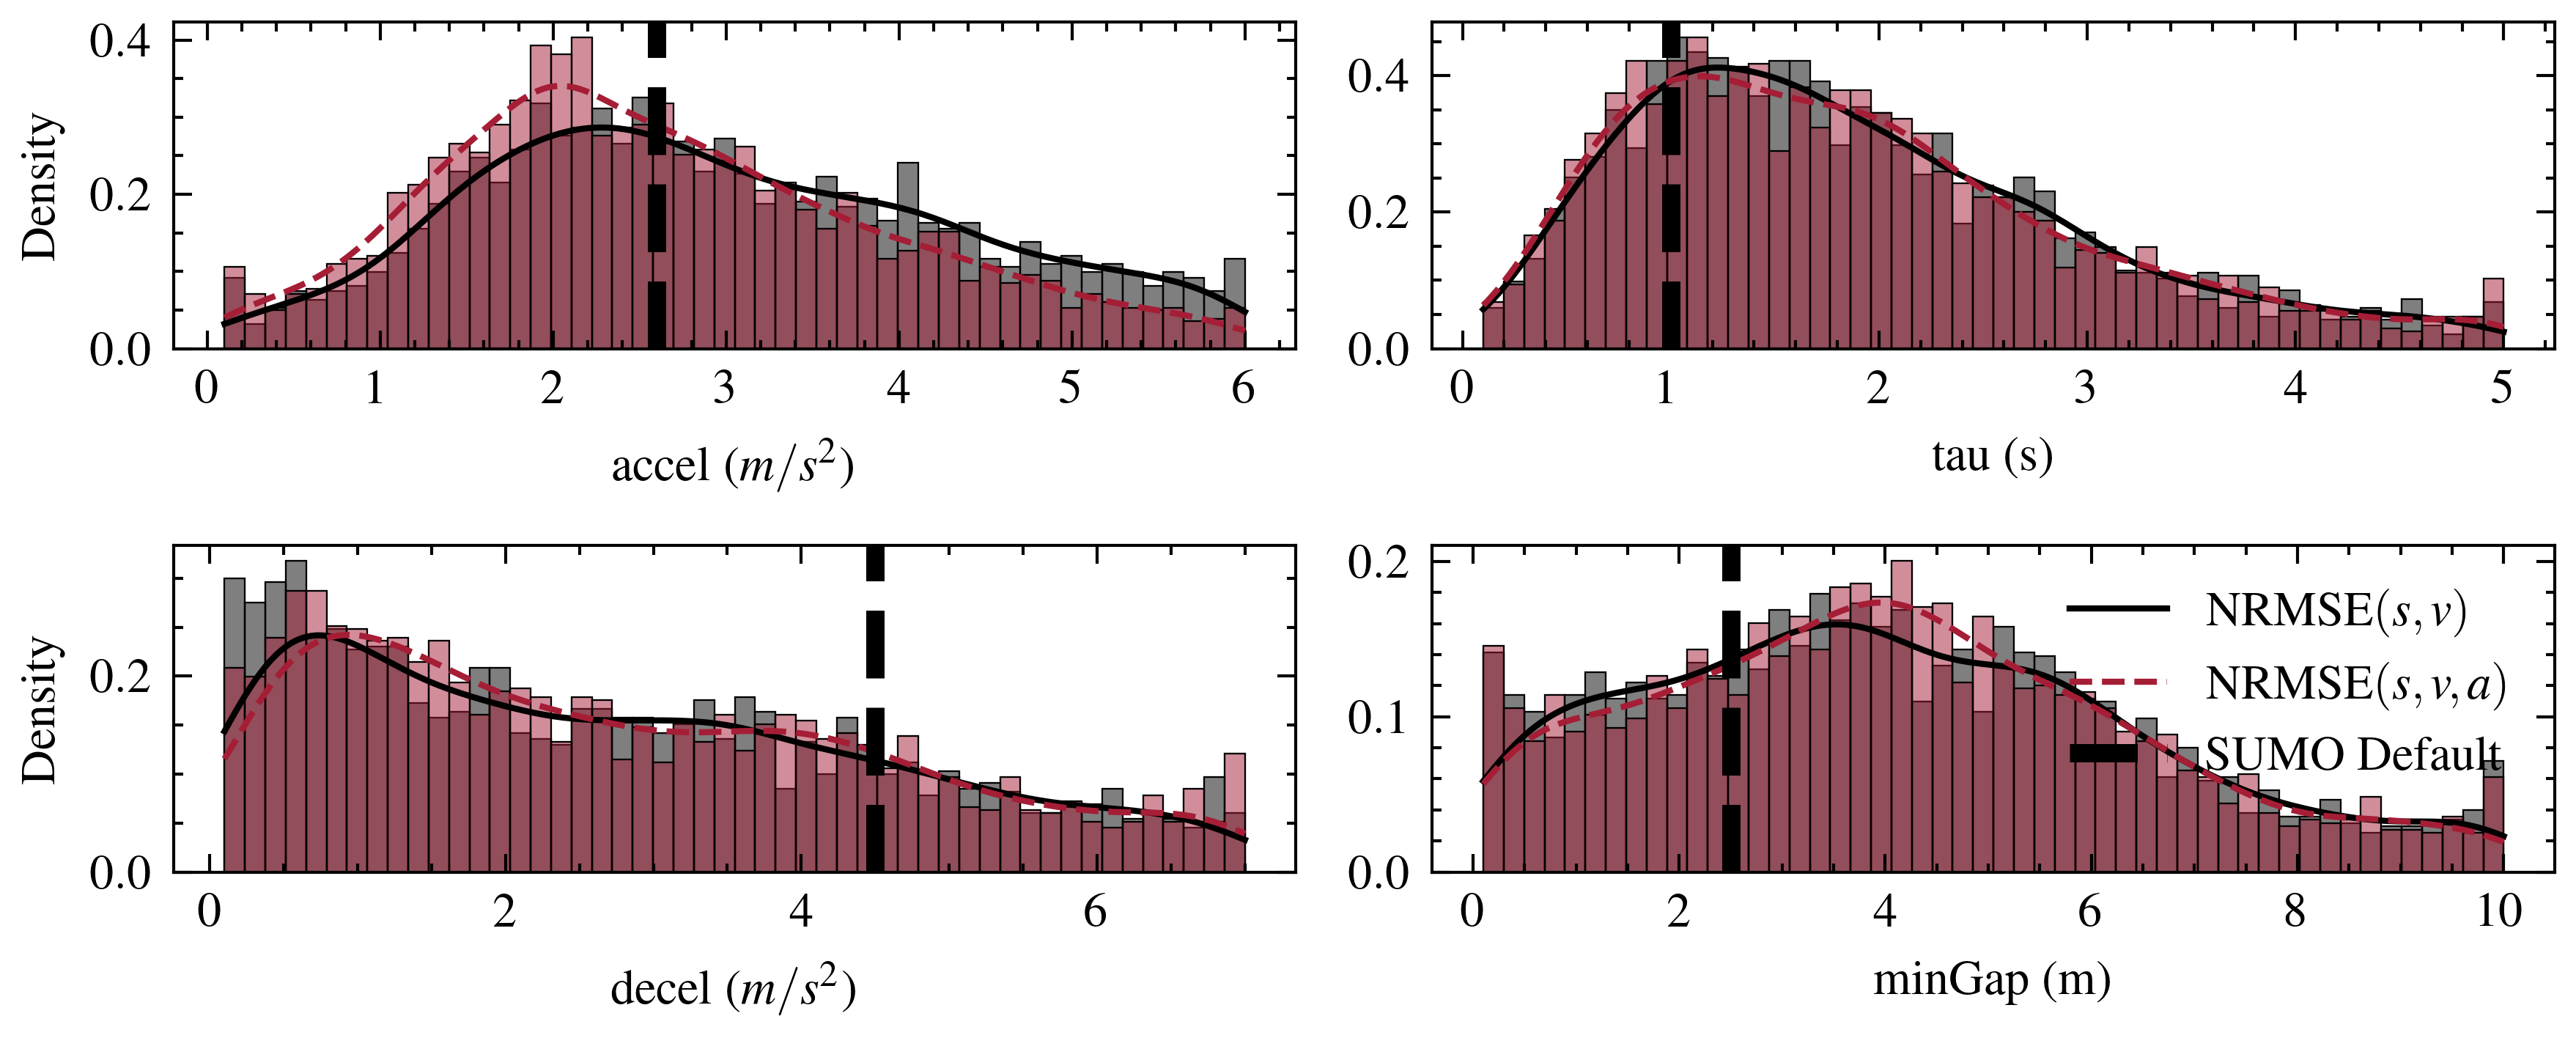

In [27]:
# histplot the acceleration
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
from sumo_default_params import attribute_dict

plt.style.use(["science", "ieee"])

# plot all the parameters in a grid
fig, axs = plt.subplots(
    2,
    2,
    # make it a big plot
    figsize=(6, 2.5),
    # share the y axis
    sharey=False,
)
axs = axs.flatten()

#
for i, (param, units) in enumerate(
    [
        ("accel", "$m/s^2$"),
        ("tau", "s"),
        ("decel", "$m/s^2$"),
        ("minGap", "m"),
        # "actionStepLength",
        # "stepping",
        # "speedFactor",
        # "delta",
    ]
):
    for j, model in enumerate(
        ["IDM - Calibrated", "IDM - Calibrated - Accel", "IDM - Calibrated - 1 sec"]
    ):
        sns.histplot(
            idm_res_df.filter(pl.col("model_pretty") == model)[param],
            kde=True,
            ax=axs[i],
            bins=50,
            stat="density",
            alpha=0.5,
            color=[plutron_color, alabama, gps_color][j],
            legend=True if i == 0 else False,
        )

    axs[i].set_xlabel(f"{param} ({units})")

# plot a vertical line at the default value
# for ax, val in zip(axs, [1, 2.6, 4.5, 2.5, 0.1, 0.1, 1, 4]):
    axs[i].axvline(attribute_dict[param], color="black", linestyle="--", linewidth=3)

# # add a legend, showing it outside the plot
plt.legend(
    ["$\\text{NRMSE}(s, v)$", "$\\text{NRMSE}(s, v, a)$", "SUMO Default"],
    # loc="center left",
    # bbox_to_anchor=(1, 0.5)
)


# turn the y-axis off for all but left plots
axs[1].set_ylabel("")
axs[3].set_ylabel("")
plt.tight_layout()

#### ingest yaml file for this run

In [28]:
from omegaconf import OmegaConf
import pandas as pd
from sumo_default_params import attribute_dict


def build_summary_df(cf_model: str, res_df: pl.DataFrame) -> pd.DataFrame:
    # read in the config
    calib_conf = OmegaConf.load(
        ROOT / f"config/sumo-pipelines/{cf_model.lower()}_calibration.yaml"
    )

    # get the bounds
    rows = []

    for k, val in calib_conf.Blocks.CFModelParameters.parameters.items():
        rows.append(
            {
                "variable": k,
                "lb": val.args[0],
                "ub": val.args[1],
                **{
                    # ("Calibrated", d["statistic"]): d["value"]
                    d["statistic"]: d["value"]
                    for d in res_df[k].describe(percentiles=[0.1, 0.5, 0.95]).to_dicts()
                    if d["statistic"] not in ["count", "min", "max", "null_count"]
                },
                # **{
                #     ("Calibrated", "skew"): res_df[k].skew(),
                #     ("Calibrated", "kurtosis"): res_df[k].kurtosis(),
                # },
            },
        )

    return pd.DataFrame(rows, )

def add_default_params(df: pd.DataFrame, ) -> pd.DataFrame:
    # get the default values
    

    # drop the model from the index
    tmp_df = df[['variable', 'lb', 'ub']].drop_duplicates().assign(
        mean=lambda x: x['variable'].map(attribute_dict),
        model='Default'
    )

    return pd.concat([df, tmp_df])



In [29]:
df = (
    pd.concat([
        build_summary_df(
            "IDM", idm_res_df.filter(pl.col("model_pretty") == "IDM - Calibrated")
        ).assign(
            model=get_label("IDM - Calibrated")
        ),
        build_summary_df(
            "IDM", idm_res_df.filter(pl.col("model_pretty") == "IDM - Calibrated - Accel")
        ).assign(
            model=get_label("IDM - Calibrated - Accel")
        ),

    ])
    .pipe(
        lambda x: add_default_params(x, )
    )
    .assign(
        lb=lambda x: x["lb"].round(1).astype(str),
        ub=lambda x: x["ub"].round(1).astype(str),
    )
    .set_index(["variable", "lb", "ub", "model"])
    .sort_index(level=[0, 3], ascending=[True, False])
    .fillna("-")
    .applymap(
        lambda x: "{:.2f}".format(x) if isinstance(x, float) else x
    )
)

latex_tb = df.to_latex(
    # index=False,
    caption="Summary statistics for the calibrated W99 model.",
    label="tab:idm-summary",
    # format the floats to 2 decimal places
    formatters=lambda x: "{:.2f}".format(x) if isinstance(x, float) else x,
    multirow=True,
)

print(latex_tb)

\begin{table}
\caption{Summary statistics for the calibrated W99 model.}
\label{tab:idm-summary}
\begin{tabular}{lllllllll}
\toprule
 &  &  &  & mean & std & 10% & 50% & 95% \\
variable & lb & ub & model &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{accel} & \multirow[t]{3}{*}{0.1} & \multirow[t]{3}{*}{6.0} & Default & 2.60 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 2.63 & 1.27 & 1.13 & 2.45 & 5.04 \\
 &  &  & $\text{NRMSE}(s, v)$ & 2.95 & 1.38 & 1.28 & 2.78 & 5.45 \\
\cline{1-9} \cline{2-9} \cline{3-9}
\multirow[t]{3}{*}{actionStepLength} & \multirow[t]{3}{*}{0.1} & \multirow[t]{3}{*}{0.2} & Default & 0.10 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 0.33 & 0.25 & 0.10 & 0.20 & 0.90 \\
 &  &  & $\text{NRMSE}(s, v)$ & 0.43 & 0.27 & 0.10 & 0.40 & 0.90 \\
\cline{1-9} \cline{2-9} \cline{3-9}
\multirow[t]{3}{*}{decel} & \multirow[t]{3}{*}{0.1} & \multirow[t]{3}{*}{7.0} & Default & 4.50 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 2.73 & 1.86 & 0.56 & 2.41 & 6.3

/tmp/ipykernel_69954/1053880691.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.concat([


In [30]:
latex_tb = df.to_latex(
    # index=False,
    caption="Summary statistics for the calibrated IDM model.",
    label="tab:idm-summary",
    # format the floats to 2 decimal places
    formatters=lambda x: "-" if isinstance(x, None) else x,
    na_rep="",
    multirow=True,
    sparsify=True
)

print(latex_tb)

\begin{table}
\caption{Summary statistics for the calibrated IDM model.}
\label{tab:idm-summary}
\begin{tabular}{lllllllll}
\toprule
 &  &  &  & mean & std & 10% & 50% & 95% \\
variable & lb & ub & model &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{accel} & \multirow[t]{3}{*}{0.1} & \multirow[t]{3}{*}{6.0} & Default & 2.60 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 2.63 & 1.27 & 1.13 & 2.45 & 5.04 \\
 &  &  & $\text{NRMSE}(s, v)$ & 2.95 & 1.38 & 1.28 & 2.78 & 5.45 \\
\cline{1-9} \cline{2-9} \cline{3-9}
\multirow[t]{3}{*}{actionStepLength} & \multirow[t]{3}{*}{0.1} & \multirow[t]{3}{*}{0.2} & Default & 0.10 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 0.33 & 0.25 & 0.10 & 0.20 & 0.90 \\
 &  &  & $\text{NRMSE}(s, v)$ & 0.43 & 0.27 & 0.10 & 0.40 & 0.90 \\
\cline{1-9} \cline{2-9} \cline{3-9}
\multirow[t]{3}{*}{decel} & \multirow[t]{3}{*}{0.1} & \multirow[t]{3}{*}{7.0} & Default & 4.50 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 2.73 & 1.86 & 0.56 & 2.41 & 6.3

## Plot Distribution of Calibrated Krauss Parameters

In [31]:
krauss_df = (
    pl.concat(
        [
            pl.scan_parquet(fps[f] / "results.parquet").with_columns(
                model_pretty=pl.lit(f)
            )
            for f in ["Krauss - Calibrated", "Krauss - Calibrated - Accel"]
        ]
    )
    .filter(~pl.col("collision"))
    .collect()
)

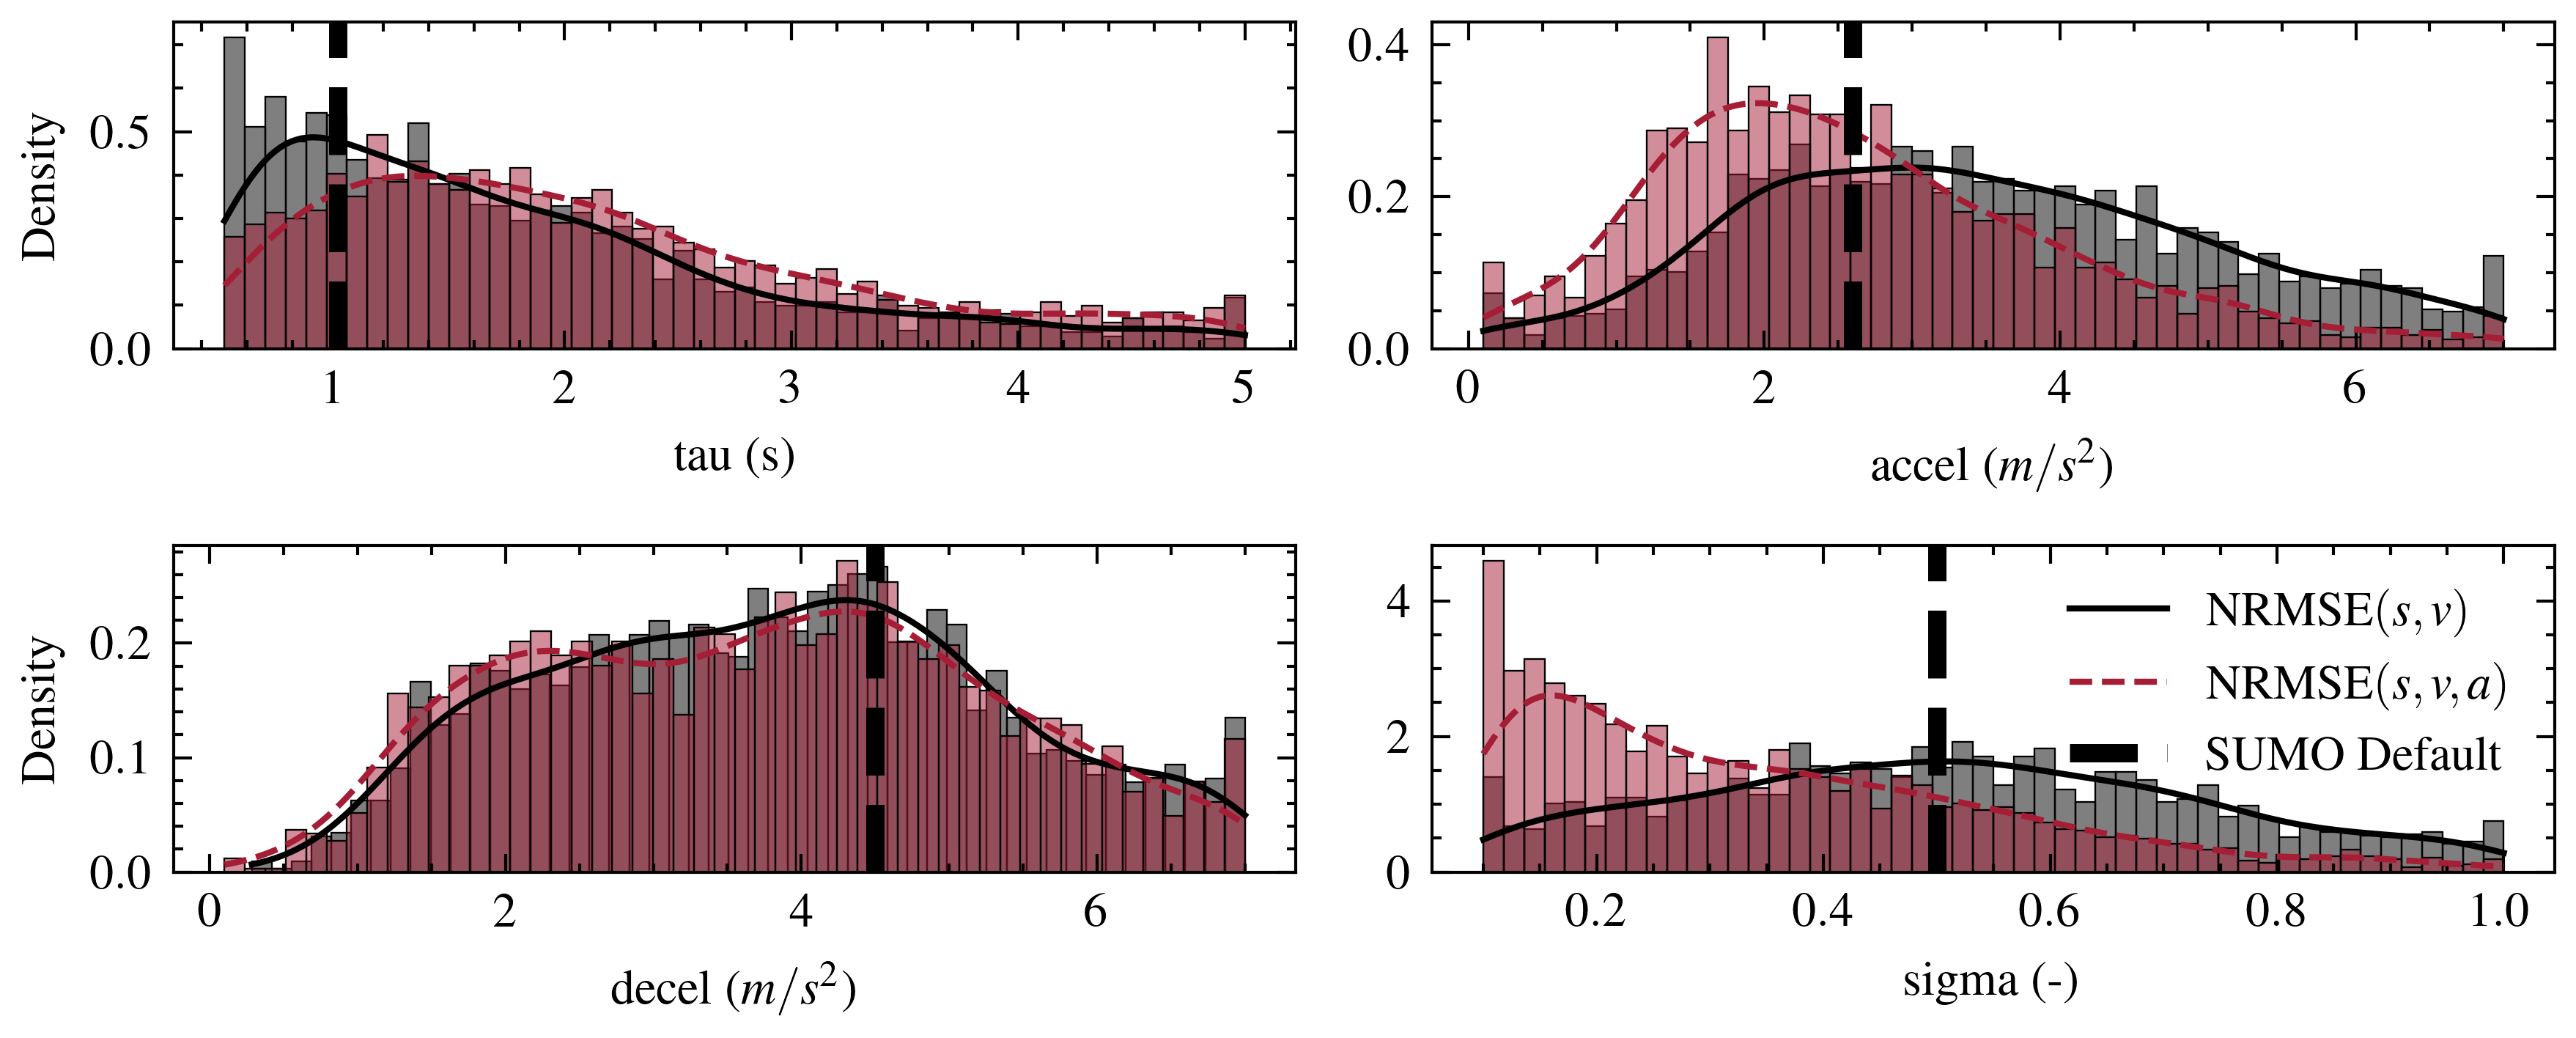

In [32]:
# histplot the acceleration
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "ieee"])


# plot all the parameters in a grid
fig, axs = plt.subplots(
    2,
    2,
    # make it a big plot
    figsize=(6, 2.5),
    # share the y axis
    sharey=False,
)
axs = axs.flatten()

for i, (param, units) in enumerate(
    [
        ("tau", "s"),
        ("accel", "$m/s^2$"),
        ("decel", "$m/s^2$"),
        ("sigma", '-'),
        # "minGap",
        # "actionStepLength",
        # "stepping",
        # "speedFactor",
        # "delta",
    ]
):
    for j, model in enumerate(["Krauss - Calibrated", "Krauss - Calibrated - Accel"]):
        sns.histplot(
            krauss_df.filter(pl.col("model_pretty") == model)[param],
            kde=True,
            ax=axs[i],
            bins=50,
            stat="density",
            alpha=0.5,
            color=[plutron_color, alabama][j],
            legend=True if i == 0 else False,
        )

    
    axs[i].set_xlabel(f"{param} ({units})")

    axs[i].axvline(attribute_dict[param], color="black", linestyle="--", linewidth=3)

# # add a legend, showing it outside the plot
plt.legend(
    ["$\\text{NRMSE}(s, v)$", "$\\text{NRMSE}(s, v, a)$", "SUMO Default"],
    # loc="center left",
    # bbox_to_anchor=(1, 0.5)
)


# turn the y-axis off for all but left plots
axs[1].set_ylabel("")
axs[3].set_ylabel("")
plt.tight_layout()

In [33]:
df = (
    pd.concat([
        build_summary_df(
            "Krauss", krauss_df.filter(pl.col("model_pretty") == "Krauss - Calibrated")
        ).assign(
            model=get_label("Krauss - Calibrated")
        ),
        build_summary_df(
            "Krauss", krauss_df.filter(pl.col("model_pretty") == "Krauss - Calibrated - Accel")
        ).assign(
            model=get_label("Krauss - Calibrated - Accel")
        ),

    ])
    .pipe(
        lambda x: add_default_params(x, )
    )
    .assign(
        lb=lambda x: x["lb"].round(1).astype(str),
        ub=lambda x: x["ub"].round(1).astype(str),
    )
    .set_index(["variable", "lb", "ub", "model"])
    .sort_index(level=[0, 3], ascending=[True, False])
    .fillna("-")
    .applymap(
        lambda x: "{:.2f}".format(x) if isinstance(x, float) else x
    )
)

latex_tb = df.to_latex(
    # index=False,
    caption="Summary statistics for the calibrated Krauss model.",
    label="tab:krauss-summary",
    # format the floats to 2 decimal places
    formatters=lambda x: "{:.2f}".format(x) if isinstance(x, float) else x,
    multirow=True,
)

print(latex_tb)

\begin{table}
\caption{Summary statistics for the calibrated Krauss model.}
\label{tab:krauss-summary}
\begin{tabular}{lllllllll}
\toprule
 &  &  &  & mean & std & 10% & 50% & 95% \\
variable & lb & ub & model &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{accel} & \multirow[t]{3}{*}{0.1} & \multirow[t]{3}{*}{7.0} & Default & 2.60 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 2.63 & 1.36 & 1.10 & 2.39 & 5.20 \\
 &  &  & $\text{NRMSE}(s, v)$ & 3.49 & 1.56 & 1.61 & 3.35 & 6.30 \\
\cline{1-9} \cline{2-9} \cline{3-9}
\multirow[t]{3}{*}{actionStepLength} & \multirow[t]{3}{*}{0.1} & \multirow[t]{3}{*}{0.2} & Default & 0.10 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 0.40 & 0.28 & 0.10 & 0.30 & 0.90 \\
 &  &  & $\text{NRMSE}(s, v)$ & 0.42 & 0.27 & 0.10 & 0.40 & 0.90 \\
\cline{1-9} \cline{2-9} \cline{3-9}
\multirow[t]{3}{*}{decel} & \multirow[t]{3}{*}{0.1} & \multirow[t]{3}{*}{7.0} & Default & 4.50 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 3.70 & 1.56 & 1.63 & 3.75

/tmp/ipykernel_69954/236594022.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.concat([


In [34]:
w99_df = (
    pl.concat(
        [
            pl.scan_parquet(fps[f] / "results.parquet").with_columns(
                model_pretty=pl.lit(f)
            )
            for f in ["W99 - Calibrated", "W99 - Calibrated - Accel"]
        ]
    )
    .filter(~pl.col("collision"))
    .collect()
)

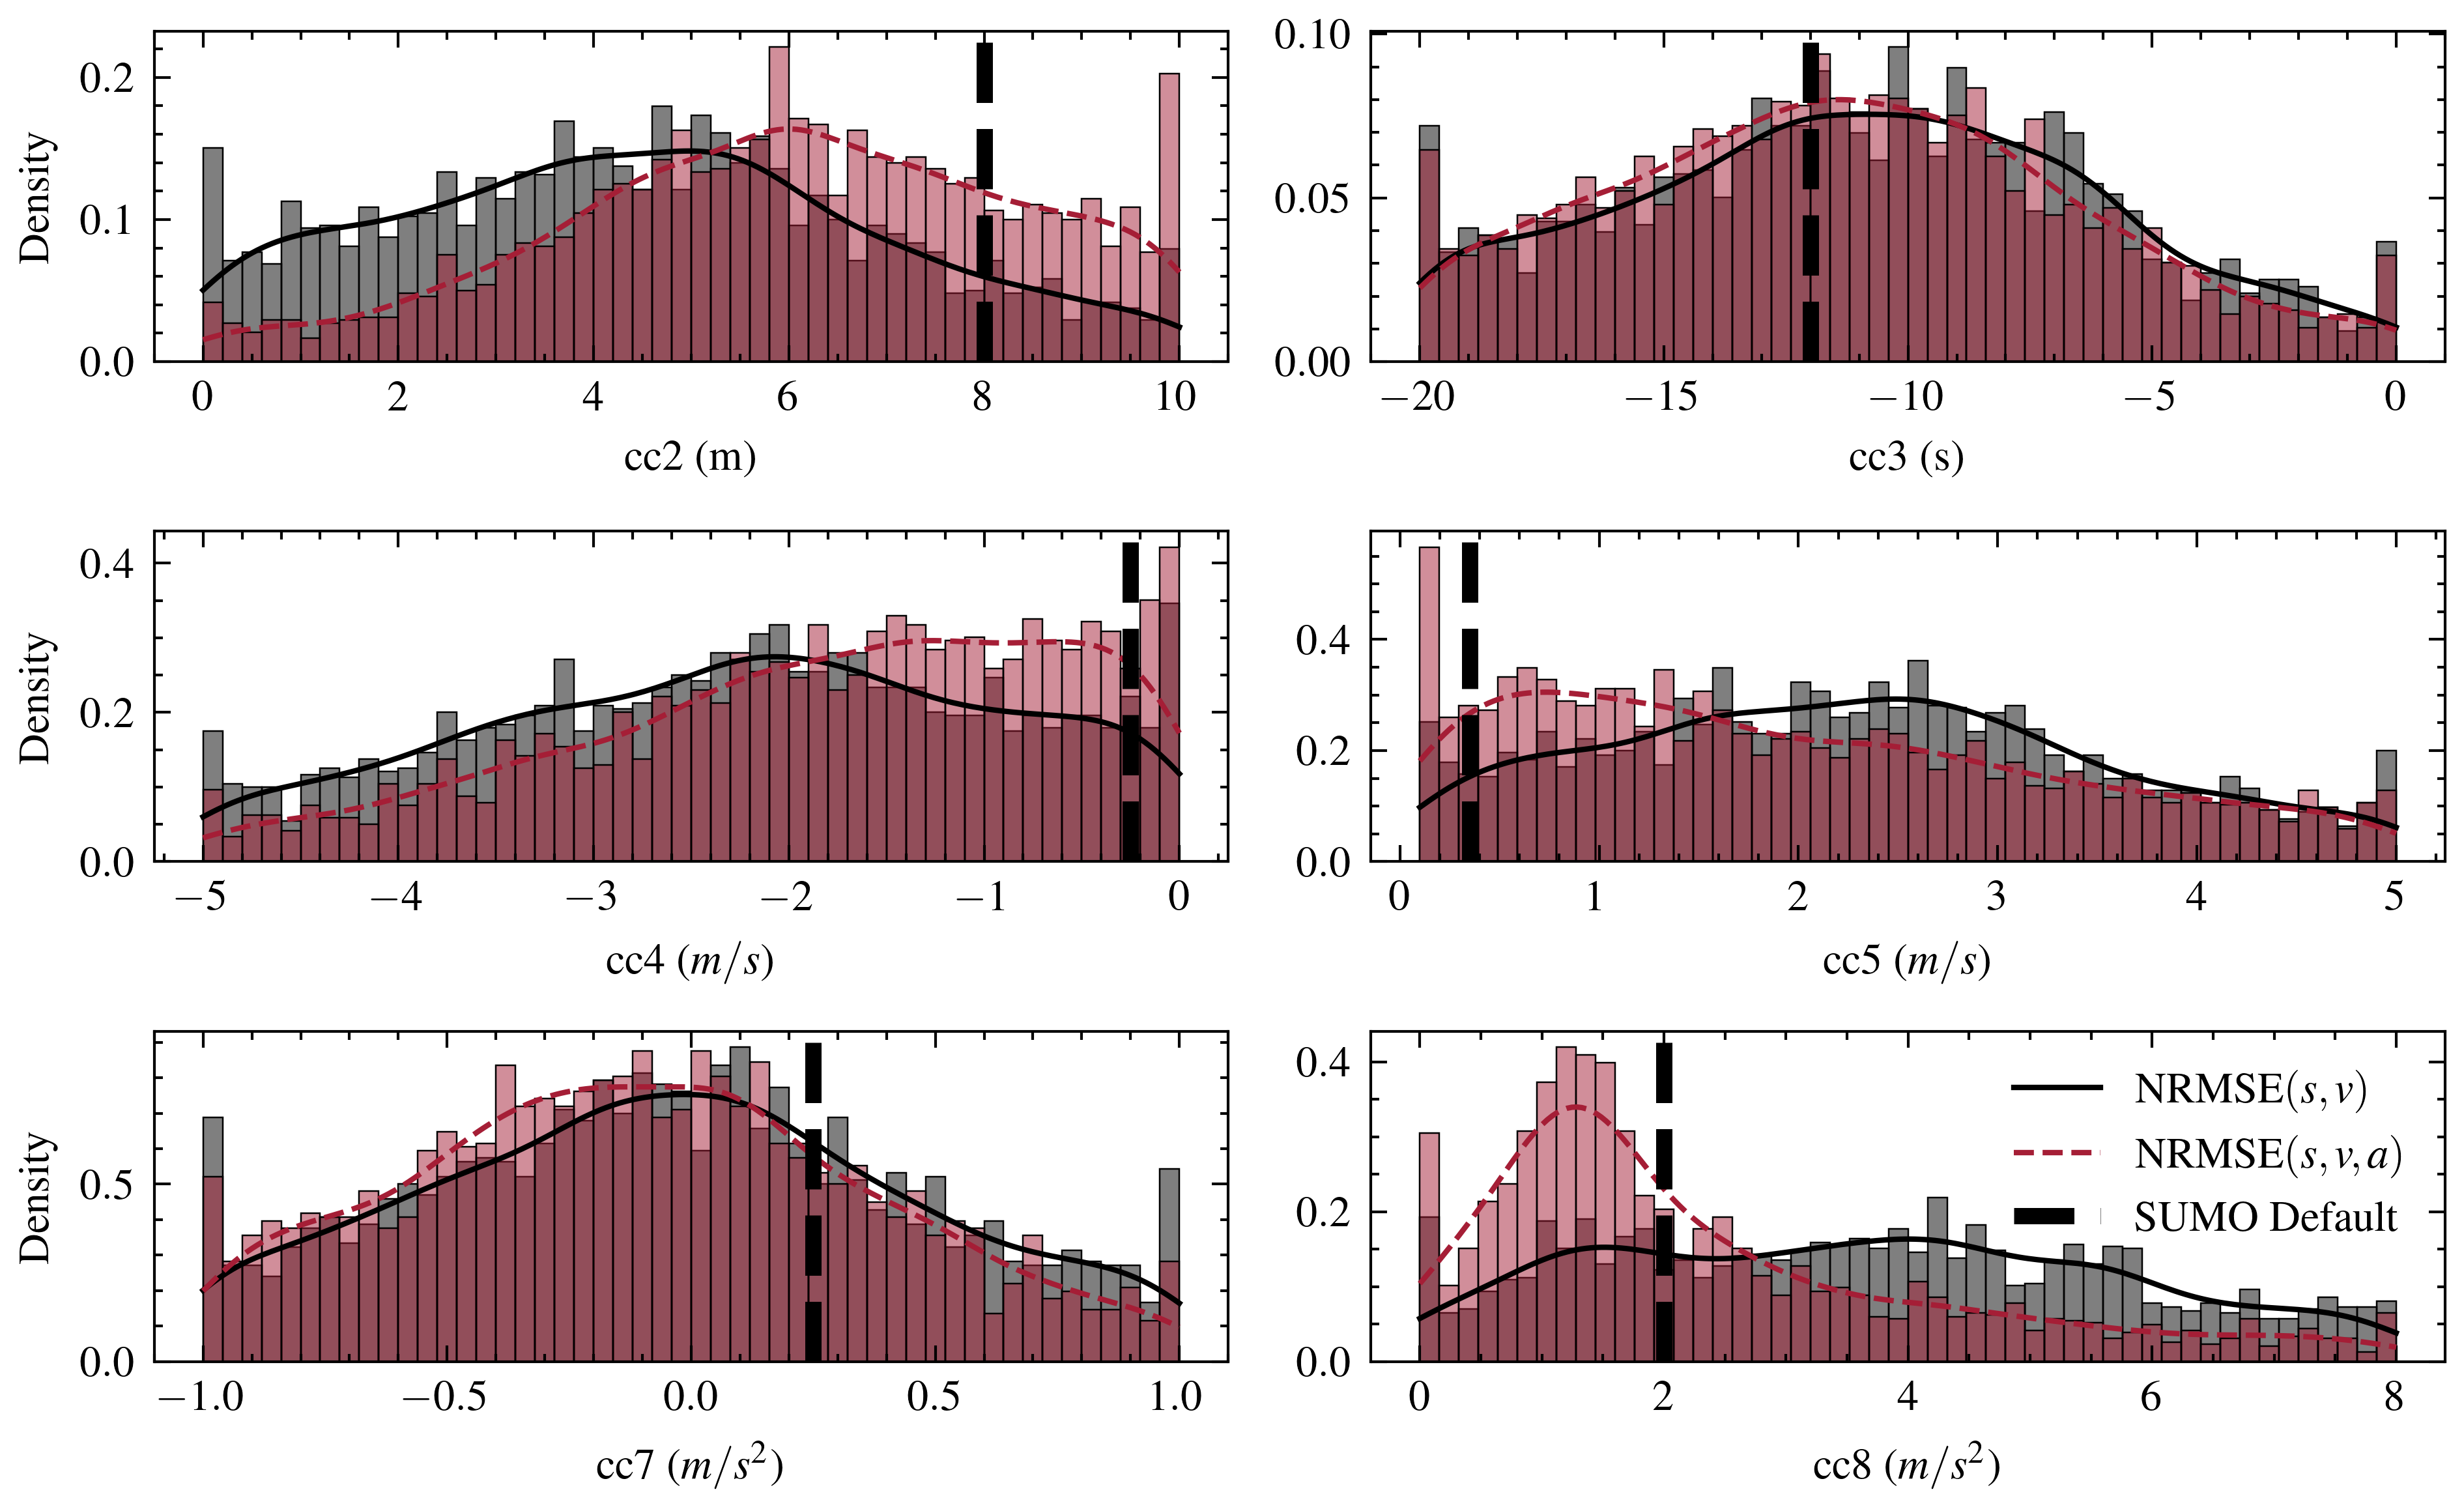

In [35]:
# histplot the acceleration
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "ieee"])


# plot all the parameters in a grid
fig, axs = plt.subplots(
    3,
    2,
    # make it a big plot
    figsize=(6.5, 4),
    # share the y axis
    sharey=False,
)
axs = axs.flatten()

for i, (param, units) in enumerate(
    [
        # "minGap",
        ("cc2", "m"),
        ("cc3", "s"),
        ("cc4", "$m/s$"),
        ("cc5", "$m/s$"),
        ("cc7", "$m/s^2$"),
        ("cc8", "$m/s^2$"),
        # "cc9"
        # "minGap",
        # "actionStepLength",
        # "stepping",
        # "speedFactor",
        # "delta",
    ]
):
    for j, model in enumerate(["W99 - Calibrated", "W99 - Calibrated - Accel"]):
        sns.histplot(
            w99_df.filter(pl.col("model_pretty") == model)[param],
            kde=True,
            ax=axs[i],
            bins=50,
            stat="density",
            alpha=0.5,
            color=[plutron_color, alabama][j],
            legend=True if i == 0 else False,
        )

    # axs[i].set_title(param)
    axs[i].set_xlabel(f"{param} ({units})")

    axs[i].axvline(attribute_dict[param], color="black", linestyle="--", linewidth=3)

    # if i is odd
    if not i % 2:
        axs[i].set_ylabel("Density")
    else:
        axs[i].set_ylabel('')
    

    

# # add a legend, showing it outside the plot
plt.legend(
    ["$\\text{NRMSE}(s, v)$", "$\\text{NRMSE}(s, v, a)$", "SUMO Default"],
    # loc="center left",
    # bbox_to_anchor=(1, 0.5)
)


# turn the y-axis off for all but left plots

plt.tight_layout()

In [36]:
df = (
    pd.concat([
        build_summary_df(
            "W99", w99_df.filter(pl.col("model_pretty") == "W99 - Calibrated")
        ).assign(
            model=get_label("Krauss - Calibrated")
        ),
        build_summary_df(
            "W99", w99_df.filter(pl.col("model_pretty") == "W99 - Calibrated - Accel")
        ).assign(
            model=get_label("W99 - Calibrated - Accel")
        ),

    ])
    .pipe(
        lambda x: add_default_params(x, )
    )
    .assign(
        lb=lambda x: x["lb"].round(1).astype(str),
        ub=lambda x: x["ub"].round(1).astype(str),
    )
    .set_index(["variable", "lb", "ub", "model"])
    .sort_index(level=[0, 3], ascending=[True, False])
    .fillna("-")
    .applymap(
        lambda x: "{:.2f}".format(x) if isinstance(x, float) else x
    )
    # .round(2)
    # .astype(str)
    # .to_latex(
    #     # index=False,
    #     caption="Summary statistics for the calibrated IDM model.",
    #     label="tab:idm-summary",
    #     # format the floats to 2 decimal places
    #     formatters={
    #         "lb": "{:.2f}".format,
    #         "ub": "{:.2f}".format,
    #         "mean": "{:.2f}".format,
    #         "10%": "{:.2f}".format,
    #         "50%": "{:.2f}".format,
    #         "95%": "{:.2f}".format,
    #     },
    # )
)

latex_tb = df.to_latex(
    # index=False,
    caption="Summary statistics for the calibrated W99 model.",
    label="tab:idm-summary",
    # format the floats to 2 decimal places
    formatters=lambda x: "{:.2f}".format(x) if isinstance(x, float) else x,
    multirow=True,
)

print(latex_tb)

\begin{table}
\caption{Summary statistics for the calibrated W99 model.}
\label{tab:idm-summary}
\begin{tabular}{lllllllll}
\toprule
 &  &  &  & mean & std & 10% & 50% & 95% \\
variable & lb & ub & model &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{actionStepLength} & \multirow[t]{3}{*}{0.1} & \multirow[t]{3}{*}{0.2} & Default & 0.10 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 0.41 & 0.27 & 0.10 & 0.40 & 0.90 \\
 &  &  & $\text{NRMSE}(s, v)$ & 0.45 & 0.28 & 0.10 & 0.40 & 1.00 \\
\cline{1-9} \cline{2-9} \cline{3-9}
\multirow[t]{3}{*}{cc1} & \multirow[t]{3}{*}{0.0} & \multirow[t]{3}{*}{5.0} & Default & 1.30 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 1.69 & 0.98 & 0.54 & 1.56 & 3.57 \\
 &  &  & $\text{NRMSE}(s, v)$ & 2.01 & 1.19 & 0.66 & 1.79 & 4.59 \\
\cline{1-9} \cline{2-9} \cline{3-9}
\multirow[t]{3}{*}{cc2} & \multirow[t]{3}{*}{0.0} & \multirow[t]{3}{*}{10.0} & Default & 8.00 & - & - & - & - \\
 &  &  & $\text{NRMSE}(s, v, a)$ & 5.99 & 2.35 & 2.78 & 6.05 & 9.65 \

/tmp/ipykernel_69954/770210789.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.concat([


In [37]:
idm_res_df[
    [
        "tau",
        "accel",
        "decel",
        "minGap",
        # "actionStepLength",
        # "stepping",
        # "speedFactor",
        # "delta",
    ]
].corr()

shape: (4, 4)
┌───────────┬───────────┬───────────┬───────────┐
│ tau       ┆ accel     ┆ decel     ┆ minGap    │
│ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╡
│ 1.0       ┆ -0.11147  ┆ 0.102115  ┆ -0.000601 │
│ -0.11147  ┆ 1.0       ┆ -0.062557 ┆ -0.025734 │
│ 0.102115  ┆ -0.062557 ┆ 1.0       ┆ 0.01279   │
│ -0.000601 ┆ -0.025734 ┆ 0.01279   ┆ 1.0       │
└───────────┴───────────┴───────────┴───────────┘

## Plot Measured vs. Modelled Distribution of Headways and Spacings

In [38]:
# leader_follower = (717,	719)
best_traj = pl.concat(
    [
        pl.concat(
            pl.scan_parquet(f).with_columns(pl.lit(int(f.parent.name)).alias("run_id"))
            for f in simulation_path.glob("*/best_trajectory.parquet")
        )
        .pipe(lambda df: df.drop("__index_level_0__"))
        .with_columns(
            model_pretty=pl.lit(name),
        )  # I have no idea why pandas does the **sometimes**
        # .filter((pl.col("leader_id") == leader_follower[0]) & (pl.col("follower_id") == leader_follower[1]))
        # .collect()
        .sort("time")
        for name, simulation_path in fps.items()
    ]
).sort("time")

In [39]:
# best_traj.fetch()

In [40]:
from functions.trajectory_processing.functions import (
    add_loess,
    calc_accel,
    calc_headway,
    calc_spacing,
)

best_traj = (
    best_traj.lazy()
    .filter(~pl.col("run_id").is_in(failed_runs))
    .with_columns(pl.struct(["model_pretty", "run_id"]).hash().alias("id"))
    .sort("time")
    # .pipe(
    #     add_loess,
    #     col="velocity_follow_sim",
    #     time_col="time",
    #     vehicle_col="id",
    #     threading=False,
    # )
    # .pipe(
    #     add_loess,
    #     col="s_follow_sim",
    #     time_col="time",
    #     vehicle_col="id",
    #     threading=False,
    # )
    .with_columns(
        # clip the min on velocity to 0
        pl.col("^velocity_follow_sim.*$").clip(lower_bound=0)
    )
    .pipe(
        calc_spacing,
        leader_pos_col="s_lead",
        follower_pos_col="s_follow",
        leader_length_col="length_lead",
        spacing_col="spacing_real",
    )
    .pipe(
        calc_spacing,
        leader_pos_col="s_lead_sim",
        follower_pos_col="s_follow_sim",
        leader_length_col="length_lead",
        spacing_col="spacing_sim",
    )
    .pipe(
        calc_accel,
        col="velocity_follow_sim",
        time_col="time_sim",
        vehicle_col="id",
        threading=True,
    )
    .pipe(
        calc_accel,
        col="velocity_follow",
        time_col="time_sim",
        vehicle_col="id",
        threading=True,
    )
    .pipe(
        calc_headway,
        leader_pos_col="s_lead",
        follower_pos_col="s_follow",
        follower_velocity_col="velocity_follow",
        headway_col="headway_real",
    )
    .pipe(
        calc_headway,
        leader_pos_col="s_lead_sim",
        follower_pos_col="s_follow_sim",
        follower_velocity_col="velocity_follow_sim",
        headway_col="headway_sim",
    )
    .collect()
)

In [41]:
best_traj.groupby(["run_id", "model_pretty"]).agg(pl.count()).group_by("run_id").agg(
    pl.col("count").n_unique()
).filter(pl.col("count") > 1)

/tmp/ipykernel_69954/2049196176.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  best_traj.groupby(["run_id", "model_pretty"]).agg(pl.count()).group_by("run_id").agg(
/tmp/ipykernel_69954/2049196176.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  best_traj.groupby(["run_id", "model_pretty"]).agg(pl.count()).group_by("run_id").agg(


shape: (0, 2)
┌────────┬───────┐
│ run_id ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
└────────┴───────┘

### Add the Power Data

In [42]:
from functions.trajectory_processing.functions import calc_instant_power

best_traj = (
    best_traj.pipe(
        calc_instant_power,
        accel_col="velocity_follow_sim_accel",
        velocity_col="velocity_follow_sim",
        output_col="power_sim",
    )
    # .pipe(
    #     calc_instant_power,
    #     accel_col="velocity_follow_sim_loess_accel",
    #     velocity_col="velocity_follow_sim_loess",
    #     output_col="power_sim_loess",
    # )
    .pipe(
        calc_instant_power,
        accel_col="velocity_follow_accel",
        velocity_col="velocity_follow",
        output_col="power_real",
    )
)

In [43]:
best_traj = best_traj.with_columns(
    # integrate the power over the id to get to energy
    (
        (pl.col("power_sim").clip(lower_bound=0).cum_sum() * pl.col("time_sim").diff())
        / 3600
    )
    .over("id")
    .alias("energy_sim_kWh"),
    # (
    #     (
    #         pl.col("power_sim_loess").clip(lower_bound=0).cum_sum()
    #         * pl.col("time_sim").diff()
    #     )
    #     / 3600
    # )
    # .over("id")
    # .alias("energy_sim_kWh_loess"),
    (
        (pl.col("power_real").clip(lower_bound=0).cum_sum() * pl.col("time_sim").diff())
        / 3600
    )
    .over("id")
    .alias("energy_real_kWh"),
)

## Plot a Single Trajectory

In [44]:
res_df.filter(
    pl.col("model_pretty").str.contains("Default")
    & ~pl.col("collision").any().over(["leader_id", "follower_id"])
).group_by(["run_id"]).agg(
    pl.col(["rmse_s", "rmse_velocity", "rmse_accel"]).mean()
).with_columns(
    (
        (pl.col(["rmse_s", "rmse_velocity", "rmse_accel"]).rank() / pl.len()) - 0.75
    ).abs(),
).with_columns(
    (
        pl.sum_horizontal(
            [
                "rmse_s",
                "rmse_velocity",
            ]
        )
        / 2
    ).alias("mean_rmse"),
).sort("mean_rmse").head()

shape: (5, 5)
┌────────┬──────────┬───────────────┬────────────┬───────────┐
│ run_id ┆ rmse_s   ┆ rmse_velocity ┆ rmse_accel ┆ mean_rmse │
│ ---    ┆ ---      ┆ ---           ┆ ---        ┆ ---       │
│ i64    ┆ f64      ┆ f64           ┆ f64        ┆ f64       │
╞════════╪══════════╪═══════════════╪════════════╪═══════════╡
│ 2317   ┆ 0.003071 ┆ 0.001229      ┆ 0.121622   ┆ 0.00215   │
│ 252    ┆ 0.002457 ┆ 0.011671      ┆ 0.149877   ┆ 0.007064  │
│ 1787   ┆ 0.0086   ┆ 0.006143      ┆ 0.040541   ┆ 0.007371  │
│ 167    ┆ 0.011057 ┆ 0.0043        ┆ 0.251229   ┆ 0.007678  │
│ 1408   ┆ 0.003686 ┆ 0.012899      ┆ 0.624079   ┆ 0.008292  │
└────────┴──────────┴───────────────┴────────────┴───────────┘

### Plot the Real Leader and Follower Headways

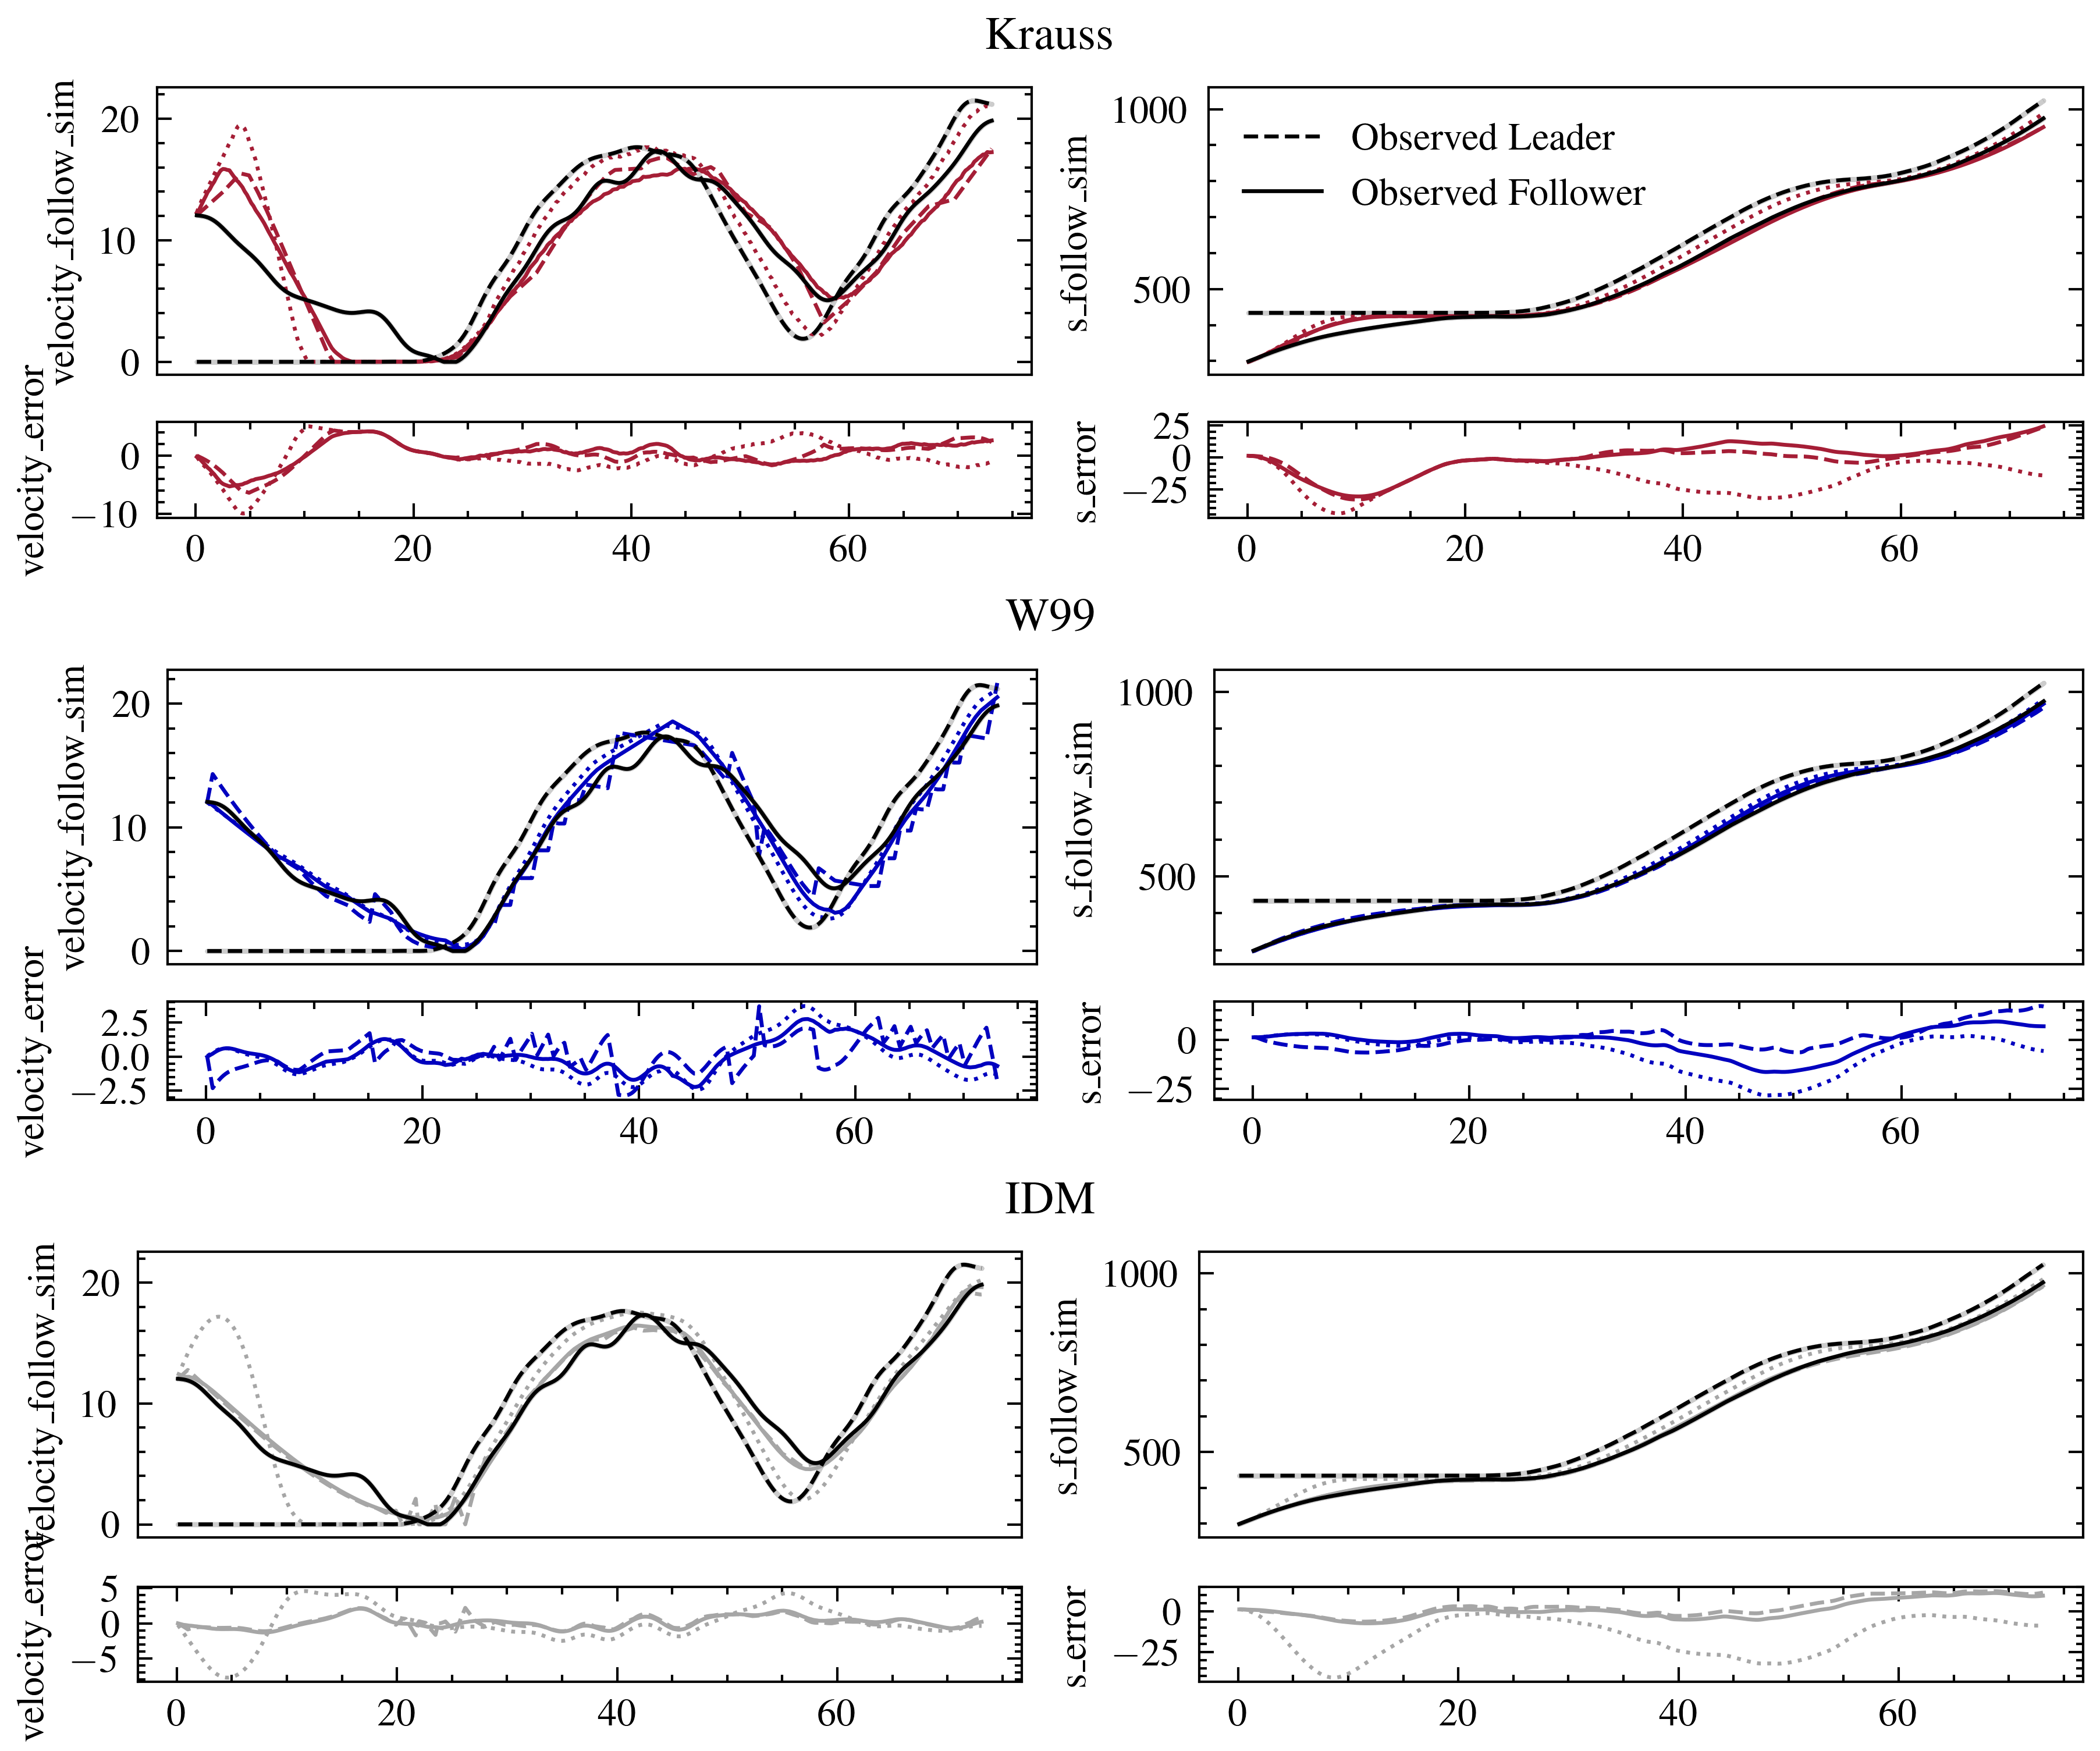

In [58]:
import seaborn as sns


fig = plt.figure(figsize=(6, 5), constrained_layout=True)
subfigs = fig.subfigures(3, 1, wspace=0.001, hspace=0.001, )

# follower = samp["follower_id"][0]  # 12467
# leader = samp["leader_id"][0]  # 12465
# leader = 567
# follower = 566
run_id = 252
# run_id = 551
# leader = 44098
# follower44102
line_width = 0.8

plot_df = best_traj.filter(pl.col("run_id") == run_id).sort("time_sim")


plot_df = plot_df.with_columns(
    ((pl.col('velocity_follow') - pl.col('velocity_follow_sim')).alias('velocity_error'),
     (pl.col('s_follow') - pl.col('s_follow_sim')).alias('s_error'))
)


for i, model in enumerate(["Krauss", "W99", "IDM"]):
    ax = subfigs[i].subplots(2, 2, gridspec_kw={"height_ratios": [3, 1]}, )
    subfigs[i].suptitle(model)

    for j, col_base in enumerate(["velocity", "s"]):
        show_legend = i == 0 and j == 1

        for k, model_pretty in enumerate(
            [
                f"{model} - Default",
                f"{model} - Calibrated",
                f"{model} - Calibrated - Accel",
            ]
        ):
            sns.lineplot(
                data=plot_df.filter(
                    pl.col("model_pretty") == f"{model_pretty}"
                ).to_pandas(),
                x="time_sim",
                y=f"{col_base}_follow_sim",
                # label=f"{model} - {get_label(model_pretty)}" if j > 0 else "_",
                label="_",
                ax=ax[0][j],
                color=get_color(model_pretty),
                linewidth=line_width,
                linestyle=get_linestyle(model_pretty),
            )

            sns.lineplot(
                data=plot_df.filter(
                    pl.col("model_pretty") == f"{model_pretty}"
                ).to_pandas(),
                x="time_sim",
                y=f"s_error" if col_base == "s" else f"velocity_error",
                # label=f"{model} - {get_label(model_pretty)}" if j > 0 else "_",
                label="_",
                ax=ax[1][j],
                color=get_color(model_pretty),
                linewidth=line_width,
                linestyle=get_linestyle(model_pretty),
            )

        sns.lineplot(
            data=plot_df.to_pandas(),
            x="time",
            y=f"{col_base}_lead",
            label="Observed Leader" if show_legend else "_",
            ax=ax[0][j],
            color="black",
            linewidth=line_width,
            linestyle="--",
        )

        sns.lineplot(
            data=plot_df.to_pandas(),
            x="time",
            y=f"{col_base}_follow",
            label="Observed Follower" if show_legend else "_",
            ax=ax[0][j],
            color="black",
            linewidth=line_width,
        )

        # turn the x-axis off
        ax[0][j].set_xlabel("")
        ax[1][j].set_xlabel("")
        # turn the ticks off
        ax[0][j].set_xticks([])
        


        # turn off the legengs

    # # update the legend text size
    # ax[1].legend(fontsize=6)

    # ax[0].set_ylabel("Velocity $(m/s)$")
    # ax[1].set_ylabel("Position $(m)$")
    # if i != 2:
    #     ax[0].set_xlabel("")
    #     ax[1].set_xlabel("")
    # else:
    #     ax[0].set_xlabel("Simulation Time $(s)$")
    #     ax[1].set_xlabel("Simulation Time $(s)$")


# plt.legend(title="Model")
# plt.tight_layout()

## Plot the Distributions

In [ ]:
from functions.trajectory_processing.functions import build_stacked_df

accel_df = best_traj.pipe(
    build_stacked_df,
    rw_value_col="velocity_follow_accel",
    sim_value_col="velocity_follow_sim_accel",
)

headway_df = best_traj.filter(
    pl.col("headway_real").is_not_nan()
    & (pl.col("velocity_follow") > 1)
    & (pl.col("velocity_follow_sim") > 1)
).pipe(
    build_stacked_df,
    rw_value_col="headway_real",
    sim_value_col="headway_sim",
)

vel_df = best_traj.pipe(
    build_stacked_df,
    rw_value_col="velocity_follow",
    sim_value_col="velocity_follow_sim",
)

power_df = best_traj.pipe(
    build_stacked_df,
    rw_value_col="power_real",
    sim_value_col="power_sim",
)

energy_df = (
    best_traj.group_by(["id", "model_pretty", "run_id"])
    .agg(pl.col(["energy_real_kWh", "energy_sim_kWh"]).last())
    .filter((pl.col("energy_real_kWh") > 0) & (pl.col("energy_sim_kWh") > 0))
    .pipe(
        build_stacked_df,
        rw_value_col="energy_real_kWh",
        sim_value_col="energy_sim_kWh",
    )
)

spacing_df = best_traj.pipe(
    build_stacked_df,
    rw_value_col="spacing_real",
    sim_value_col="spacing_sim",
)

# energy_df_loess = (
#     best_traj.group_by(["id", "model_pretty"])
#     .agg(pl.col(["energy_real_kWh", "energy_sim_kWh_loess"]).last())
#     .pipe(
#         build_stacked_df,
#         rw_value_col="energy_real_kWh",
#         sim_value_col="energy_sim_kWh_loess",
#     )
# )

In [ ]:
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

plt.style.use(["science", "ieee"])
import numpy as np

colors = [
    engine_color,
    alabama,
    # plutron_color,
    gps_color,
]


def dash_mapping(model):
    if "Calibrated - Accel" in model:
        return "-"
    elif "Calibrated" in model:
        return ":"
    else:
        return "-."


def plot_cdf(df, ax, ax_label, **kwargs):
    # plot the cdf
    # plot the cdfs
    # import numpy as np

    # fig, ax = plt.subplots(1, 1)
    for model, df in df.sort("model").group_by(
        [
            "model_pretty",
        ],
        keep_sorted=True,
    ):
        x = np.sort(df["value"].to_numpy())
        y = np.arange(1, len(x) + 1) / len(x)
        if "Real" in model[0]:
            ax.plot(
                x,
                y,
                label=model[0],
                linewidth=2,
                # alpha=0.5,
                linestyle="-",
                color="black",
                # set the zorder to be the lowest
                zorder=0,
            )
        else:
            ax.plot(
                x,
                y,
                label=f"{model[0].split(' - ')[0]} - {get_label(model[0])}",
                linewidth=1,
                alpha=1,
                linestyle=get_linestyle(
                    model[0],
                ),
                color=get_color(
                    model[0],
                ),
            )

    ax.set_xlabel(ax_label)

(-140.0, 140.0)

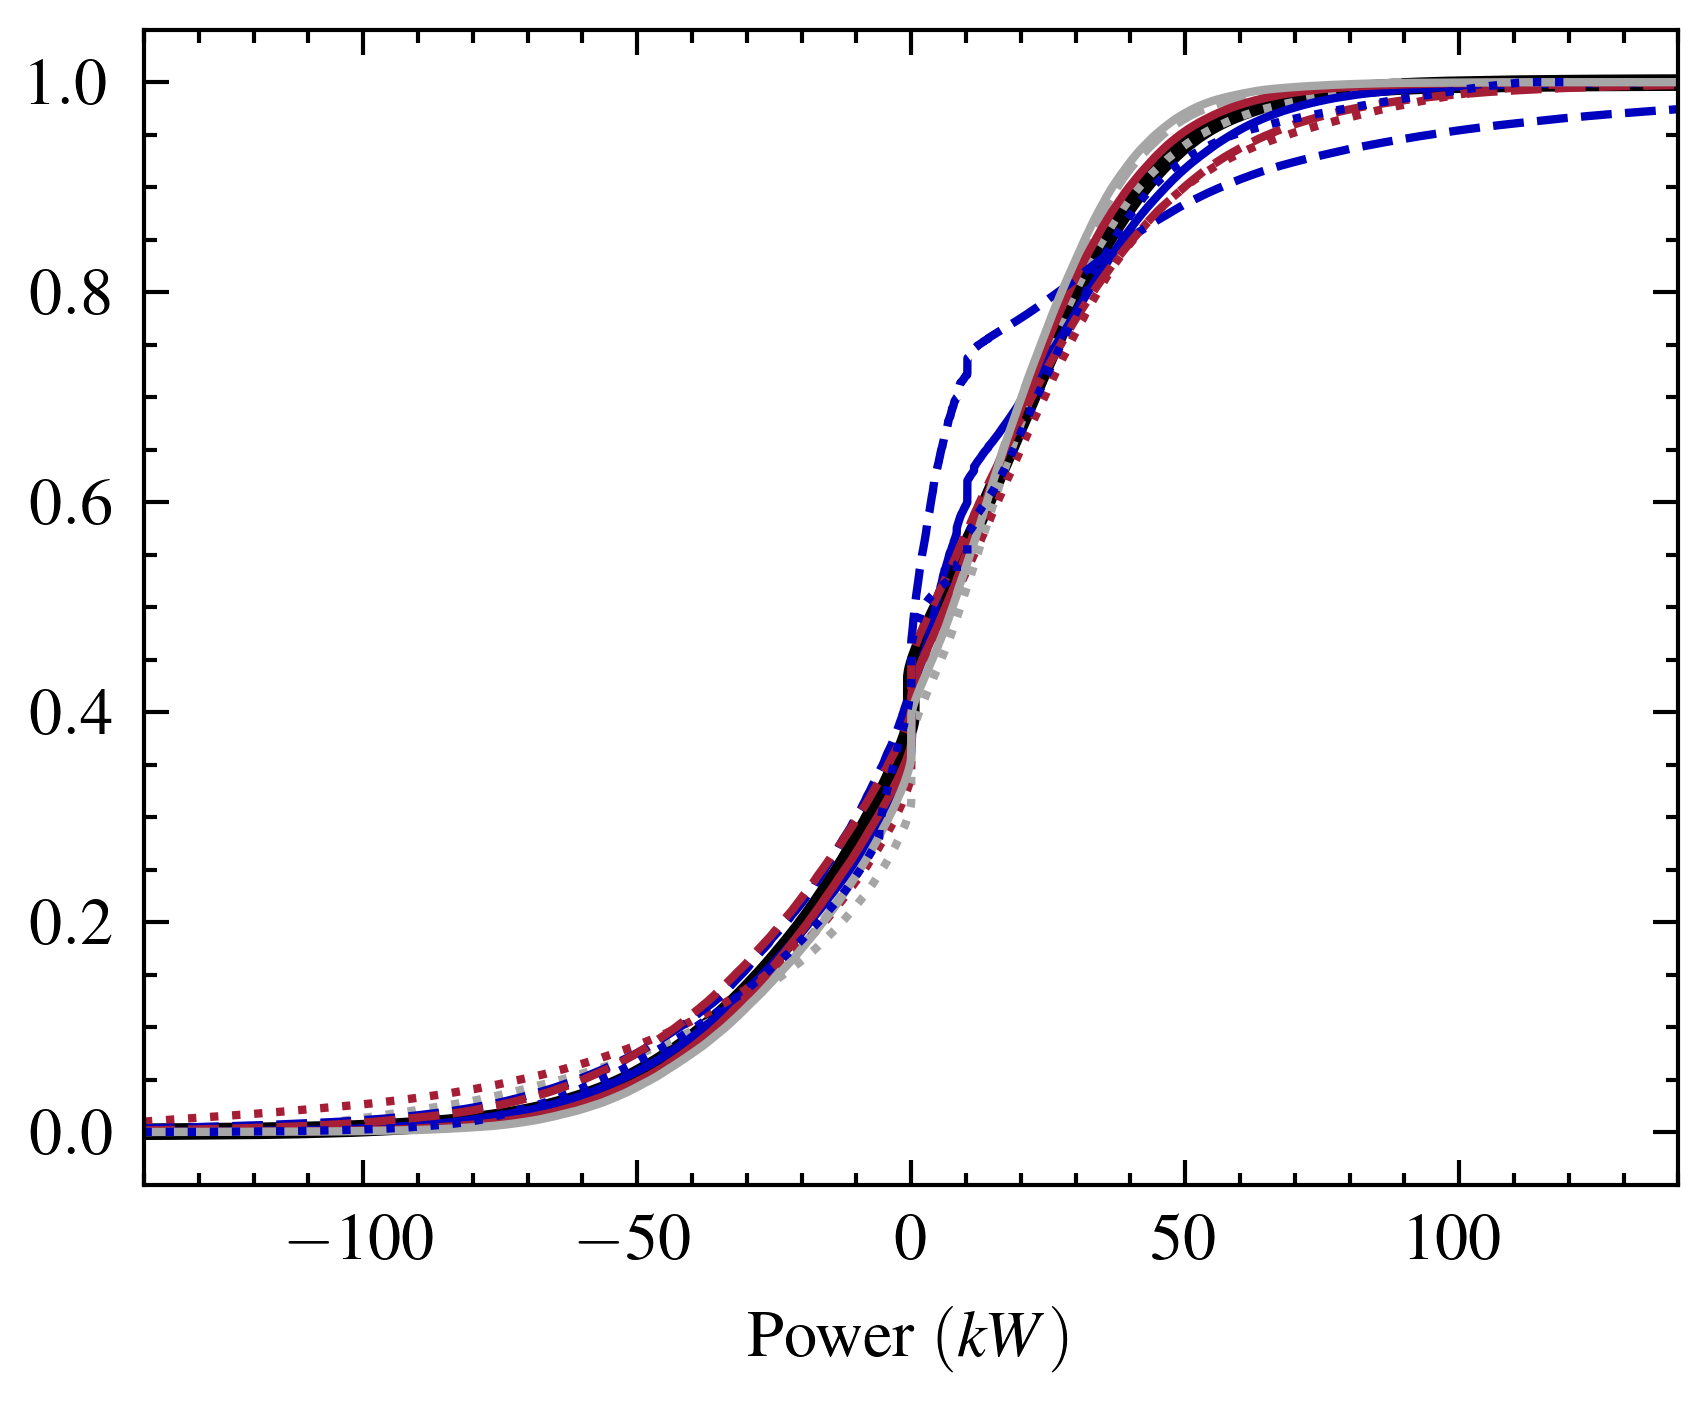

In [ ]:
# plot the cdf of power
fig, ax = plt.subplots(1, 1)

plot_cdf(power_df, ax, "Power $(kW)$")

# set the axis limits
ax.set_xlim(-140, 140)

# # turn on the legend
# plt.legend(title="Model")

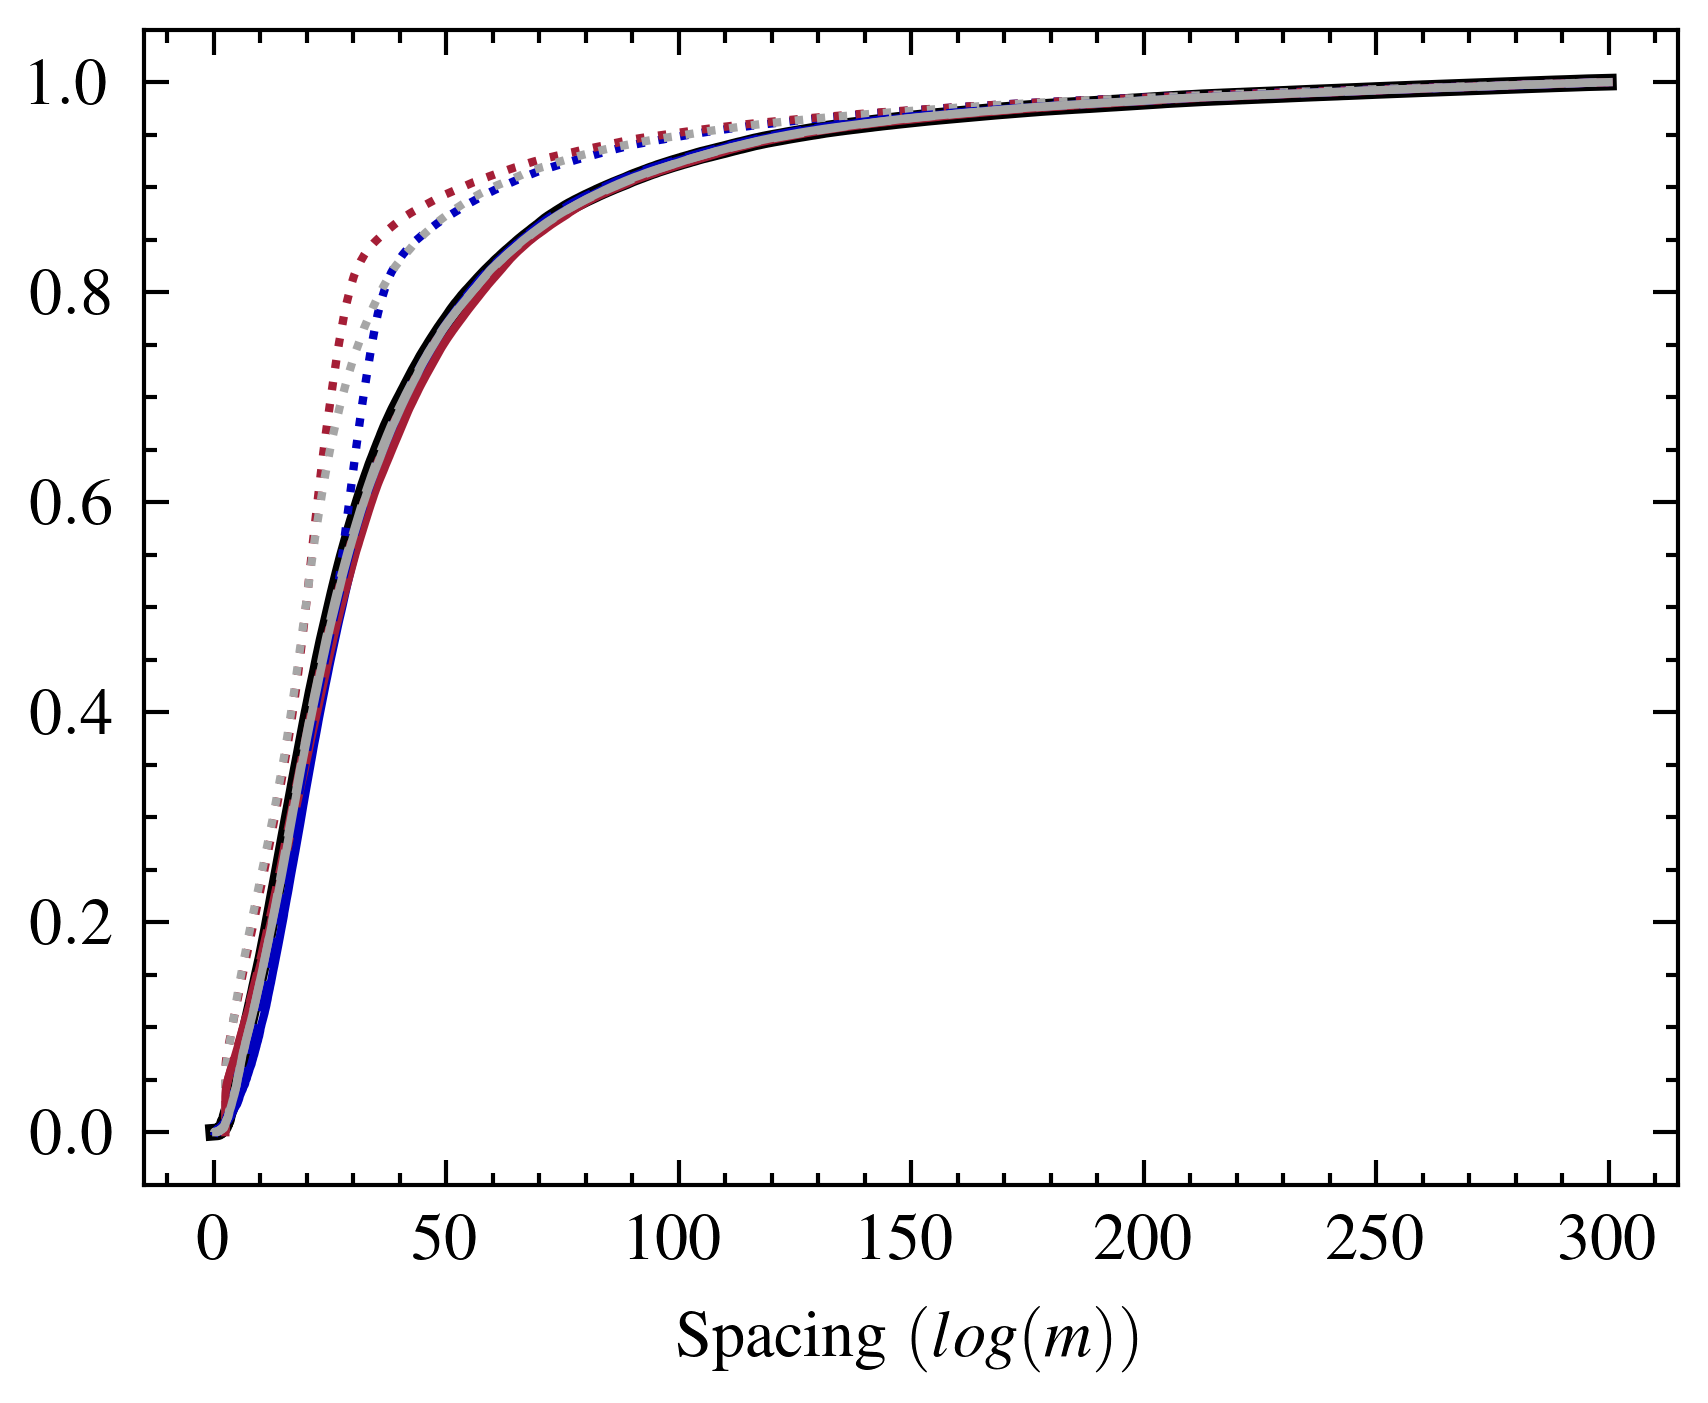

In [ ]:
# plot the cdf of power
fig, ax = plt.subplots(1, 1)

plot_cdf(
    spacing_df.with_columns(pl.col("value")).filter(pl.col("value").is_between(0, 300)),
    ax,
    "Spacing $(log(m))$",
)
# make the y-axis log
# ax.set_yscale("log")

# set the axis limits
# ax.set_xlim(-140, 140)

# # turn on the legend
# plt.legend(title="Model")

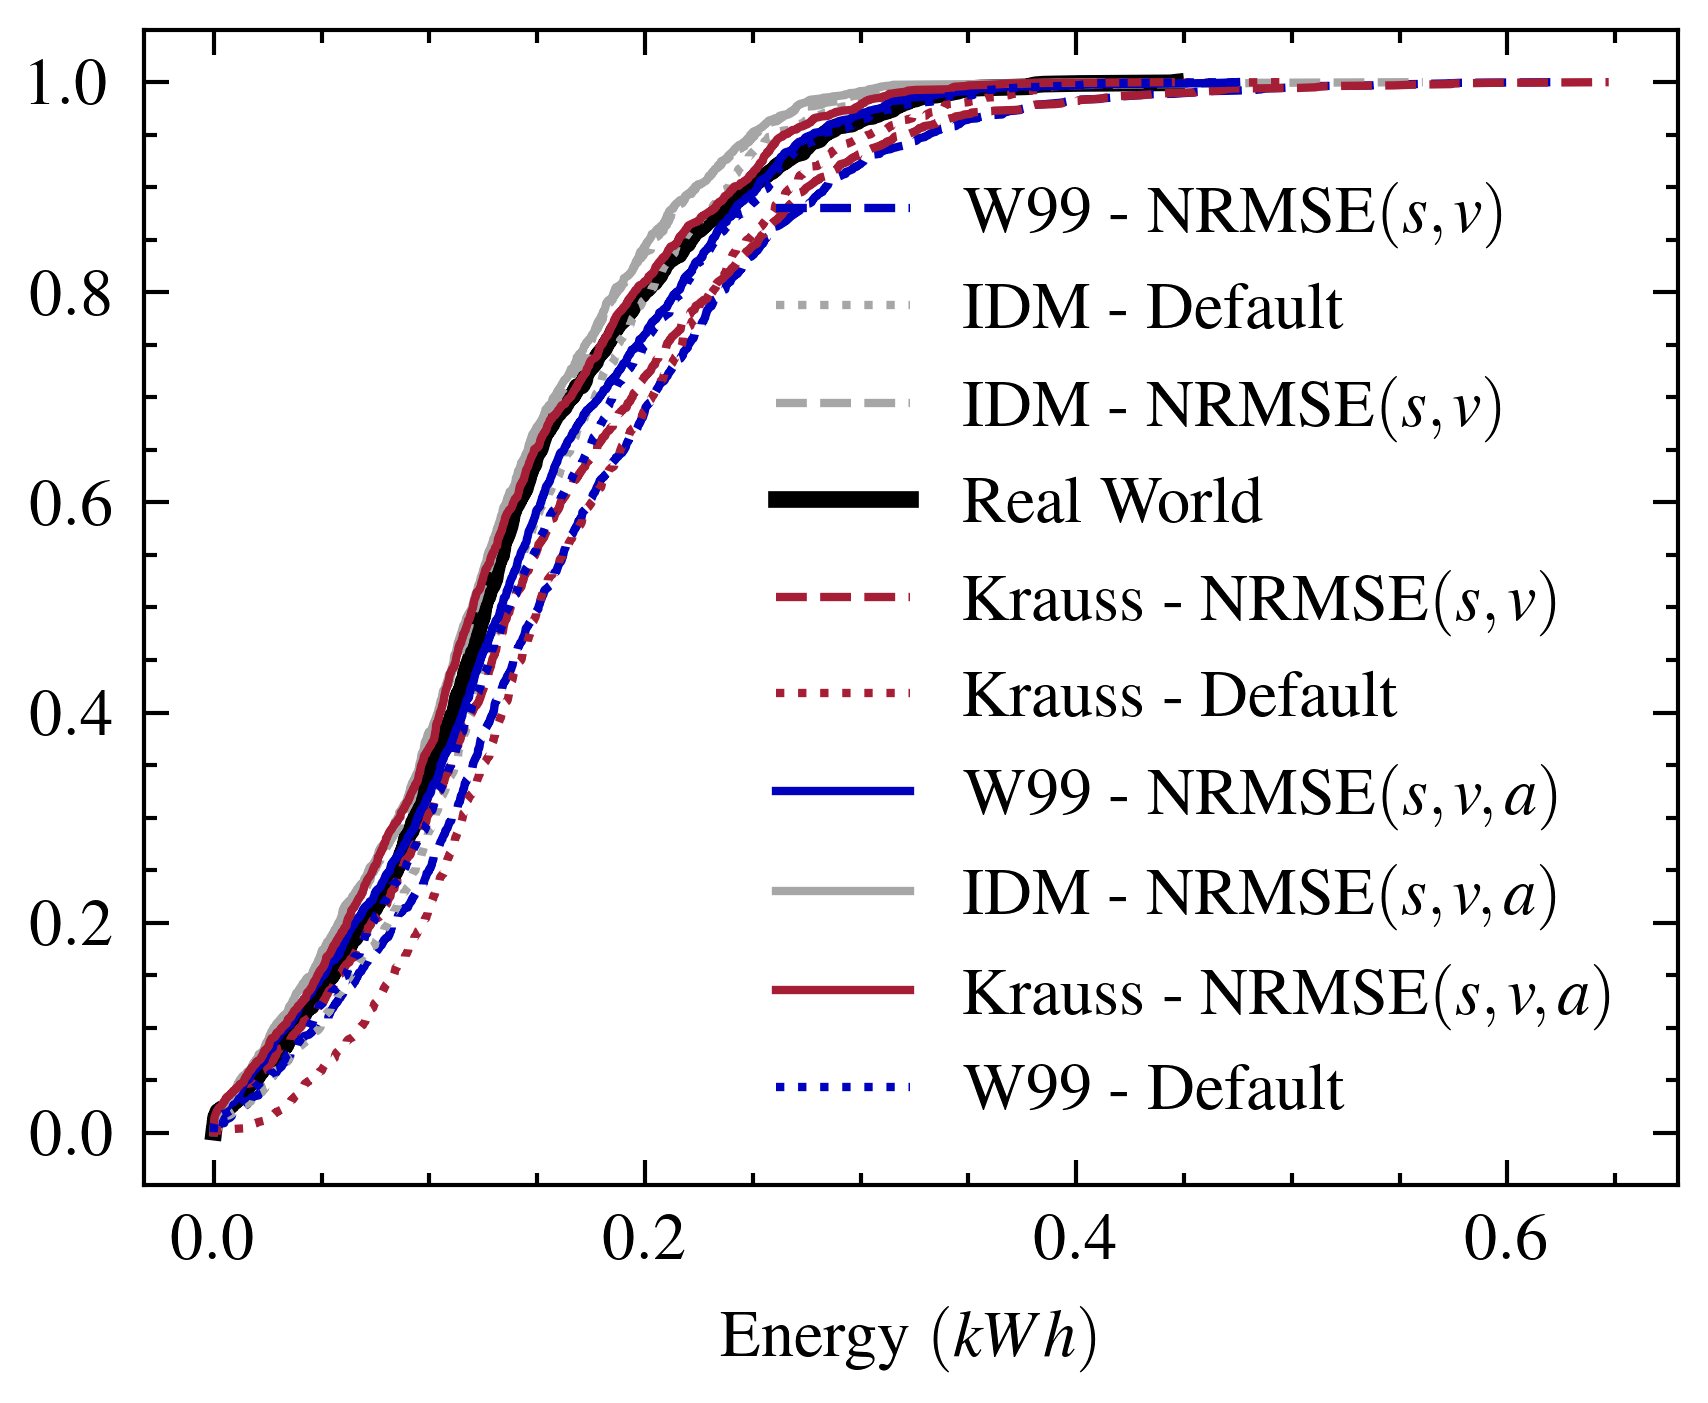

In [ ]:
# plot the cdf of power
fig, ax = plt.subplots(1, 1)

plot_cdf(energy_df, ax, "Energy $(kWh)$")

# turn on the legend
plt.legend(title="")
# sort the legend

In [ ]:
energy_df.filter(pl.col("value").is_nan())

shape: (0, 6)
┌──────────────┬────────┬──────────┬───────┬────────────┬───────┐
│ model_pretty ┆ run_id ┆ variable ┆ value ┆ calibrated ┆ model │
│ ---          ┆ ---    ┆ ---      ┆ ---   ┆ ---        ┆ ---   │
│ str          ┆ i32    ┆ str      ┆ f64   ┆ bool       ┆ str   │
╞══════════════╪════════╪══════════╪═══════╪════════════╪═══════╡
└──────────────┴────────┴──────────┴───────┴────────────┴───────┘

In [ ]:
energy_df.filter(pl.col("model_pretty") == "Real World").to_pandas()["value"]

0       0.036366
1       0.100102
2       0.194250
3       0.204239
4       0.020266
          ...   
1624    0.087141
1625    0.094720
1626    0.137607
1627    0.041111
1628    0.000120
Name: value, Length: 1629, dtype: float64

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

# # create an empty dataframe
# # calculate the correlation between the real and simulated energy

# energy_df = energy_df.filter(

# )

correlation_data = []
for m in best_traj["model_pretty"].unique():
    model_df = (
        best_traj.filter((pl.col("model_pretty") == m))
        .filter(
            (
                pl.col("energy_real_kWh").is_not_nan()
                & pl.col("energy_real_kWh").is_not_null()
            )
            & (
                pl.col("energy_sim_kWh").is_not_nan()
                & pl.col("energy_sim_kWh").is_not_null()
            )
        )
        .sort(["run_id", "time_sim"])
        .group_by(["run_id", "model_pretty"])
        .agg(
            pl.col("energy_real_kWh").last().alias("energy_real_kWh"),
            pl.col("energy_sim_kWh").last().alias("energy_sim_kWh"),
        )
        # .select("accel_follow")
        .to_pandas()[["energy_real_kWh", "energy_sim_kWh"]]
    )
    real_energy = model_df["energy_real_kWh"]
    sim_energy = model_df["energy_sim_kWh"]

    # real_energy = (
    #     energy_df.filter(pl.col("model_pretty") == "Real World")
    #     .sort("run_id")
    #     .to_pandas()["value"]
    # )
    # sim_energy = (
    #     energy_df.filter(pl.col("model_pretty") == m)
    #     .sort("run_id")
    #     .to_pandas()["value"]
    # )

    # break

    # calculate the R2 score
    r2 = r2_score(real_energy, sim_energy)

    # calculate the Pearson correlation coefficient
    pearson_r = pearsonr(real_energy, sim_energy)[0]

    mse = mean_squared_error(real_energy, sim_energy)
    mape = mean_absolute_percentage_error(real_energy, sim_energy)

    # add the results to the dataframe
    # df = df.append({'Model': m, 'R2 Score': r2, 'Pearson R': pearson_r, }, ignore_index=True)

    correlation_data.append(
        {
            "Model": (m.split(" - ")[0], get_label(m)),
            # ("Model Evaluation", "Pearson r"): pearson_r,
            ("Model Evaluation", "$R^2$"): r2,
            ("Model Evaluation", "RMSE"): np.sqrt(mse),
            ("Summary Statistics", "$P_{50\%}$"): np.percentile(sim_energy, 50),
            ("Summary Statistics", "$P_{90\%}$"): np.percentile(sim_energy, 90),
            ("Summary Statistics", "$P_{99\%}$"): np.percentile(sim_energy, 99),
            ("Summary Statistics", "Total"): np.sum(sim_energy),
        }
    )


#  add a row for the real world data
correlation_data.append(
    {
        "Model": ("Real World", "Observed"),
        # ("Model Evaluation", "Pearson r"): None,
        ("Model Evaluation", "$R^2$"): None,
        ("Model Evaluation", "RMSE"): None,
        ("Summary Statistics", "$P_{50\%}$"): np.percentile(real_energy, 50),
        ("Summary Statistics", "$P_{90\%}$"): np.percentile(real_energy, 90),
        ("Summary Statistics", "$P_{99\%}$"): np.percentile(real_energy, 99),
        ("Summary Statistics", "Total"): np.sum(real_energy),
    }
)


correlation_df = pd.DataFrame(correlation_data)
correlation_df = correlation_df.set_index(
    pd.MultiIndex.from_tuples(correlation_df["Model"], names=["Model", "Model Label"])
).drop("Model", axis=1)

# make the columns a multiindex
correlation_df.columns = pd.MultiIndex.from_tuples(correlation_df.columns)

correlation_df = correlation_df.sort_index().sort_index(axis=1)
correlation_df.head(20)

Model Evaluation            \
                                              $R^2$      RMSE   
Model      Model Label                                          
IDM        $\text{NRMSE}(s, v)$            0.853393  0.030080   
           $\text{NRMSE}(s, v, a)$         0.872588  0.028042   
           Default                         0.785183  0.036411   
Krauss     $\text{NRMSE}(s, v)$            0.584029  0.050668   
           $\text{NRMSE}(s, v, a)$         0.885874  0.026540   
           Default                         0.589841  0.050313   
Real World Observed                             NaN       NaN   
W99        $\text{NRMSE}(s, v)$            0.486314  0.056305   
           $\text{NRMSE}(s, v, a)$         0.851039  0.030321   
           Default                         0.775120  0.037254   

                                   Summary Statistics                        \
                                           $P_{50\%}$ $P_{90\%}$ $P_{99\%}$   
Model      Model Label                                                        
IDM        $\text{NRMSE}(s, v)$              0.120597   0.223654   0.305807   
           $\text{NRMSE}(s, v, a)$           0.119111   0.222957   0.297400   
           Default                           0.134146   0.238568   0.323094   
Krauss     $\text{NRMSE}(s, v)$              0.137426   0.274902   0.451391   
           $\text{NRMSE}(s, v, a)$           0.119792   0.240866   0.317023   
           Default                           0.150293   0.267904   0.374041   
Real World Observed                          0.125329   0.247314   0.341663   
W99        $\text{NRMSE}(s, v)$              0.150599   0.283748   0.452946   
           $\text{NRMSE}(s, v, a)$           0.132844   0.252135   0.341603   
           Default                           0.135659   0.256684   0.355675   

                                                
                                         Total  
Model      Model Label                          
IDM        $\text{NRMSE}(s, v)$     204.574592  
           $\text{NRMSE}(s, v, a)$  201.007214  
           Default                  229.780335  
Krauss     $\text{NRMSE}(s, v)$     250.053217  
           $\text{NRMSE}(s, v, a)$  210.643702  
           Default                  265.932003  
Real World Observed                 221.457938  
W99        $\text{NRMSE}(s, v)$     265.378904  
           $\text{NRMSE}(s, v, a)$  226.963572  
           Default                  236.173900

In [ ]:
# make it latex, round to 3 decimal places
print(
    correlation_df.to_latex(
        caption="Model evaluation metrics for the energy consumption of the calibrated car following models.",
        label="tab:energy-model-eval",
        # bold the min
        formatters={
            ("Model Evaluation", "RMSE"): lambda x: (
                "\\textbf{" + str(round(x, 3)) + "}"
                if x == correlation_df[("Model Evaluation", "RMSE")].min()
                else str(round(x, 3))
            ),
            ("Model Evaluation", "$R^2$"): lambda x: (
                "\\textbf{" + str(round(x, 3)) + "}"
                if x == correlation_df[("Model Evaluation", "$R^2$")].max()
                else str(round(x, 3))
            ),
            ("Model Evaluation", "Pearson r"): lambda x: (
                "\\textbf{" + str(round(x, 3)) + "}"
                if x == correlation_df[("Model Evaluation", "Pearson r")].max()
                else str(round(x, 3))
            ),
            # round all the other values to 3 decimal places
            **{
                k: "{:.3f}".format
                for k in correlation_df.columns
                if k
                not in [
                    ("Model Evaluation", "RMSE"),
                    ("Model Evaluation", "$R^2$"),
                    ("Model Evaluation", "Pearson r"),
                ]
            },
        },
    )
)

\begin{table}
\caption{Model evaluation metrics for the energy consumption of the calibrated car following models.}
\label{tab:energy-model-eval}
\begin{tabular}{llrrrrrr}
\toprule
 &  & \multicolumn{2}{r}{Model Evaluation} & \multicolumn{4}{r}{Summary Statistics} \\
 &  & $R^2$ & RMSE & $P_{50\%}$ & $P_{90\%}$ & $P_{99\%}$ & Total \\
Model & Model Label &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{IDM} & $\text{NRMSE}(s, v)$ & 0.853 & 0.03 & 0.121 & 0.224 & 0.306 & 204.575 \\
 & $\text{NRMSE}(s, v, a)$ & 0.873 & 0.028 & 0.119 & 0.223 & 0.297 & 201.007 \\
 & Default & 0.785 & 0.036 & 0.134 & 0.239 & 0.323 & 229.780 \\
\cline{1-8}
\multirow[t]{3}{*}{Krauss} & $\text{NRMSE}(s, v)$ & 0.584 & 0.051 & 0.137 & 0.275 & 0.451 & 250.053 \\
 & $\text{NRMSE}(s, v, a)$ & \textbf{0.886} & \textbf{0.027} & 0.120 & 0.241 & 0.317 & 210.644 \\
 & Default & 0.59 & 0.05 & 0.150 & 0.268 & 0.374 & 265.932 \\
\cline{1-8}
Real World & Observed & NaN & NaN & 0.125 & 0.247 & 0.342 & 221.458 \\
\cline{1-8}


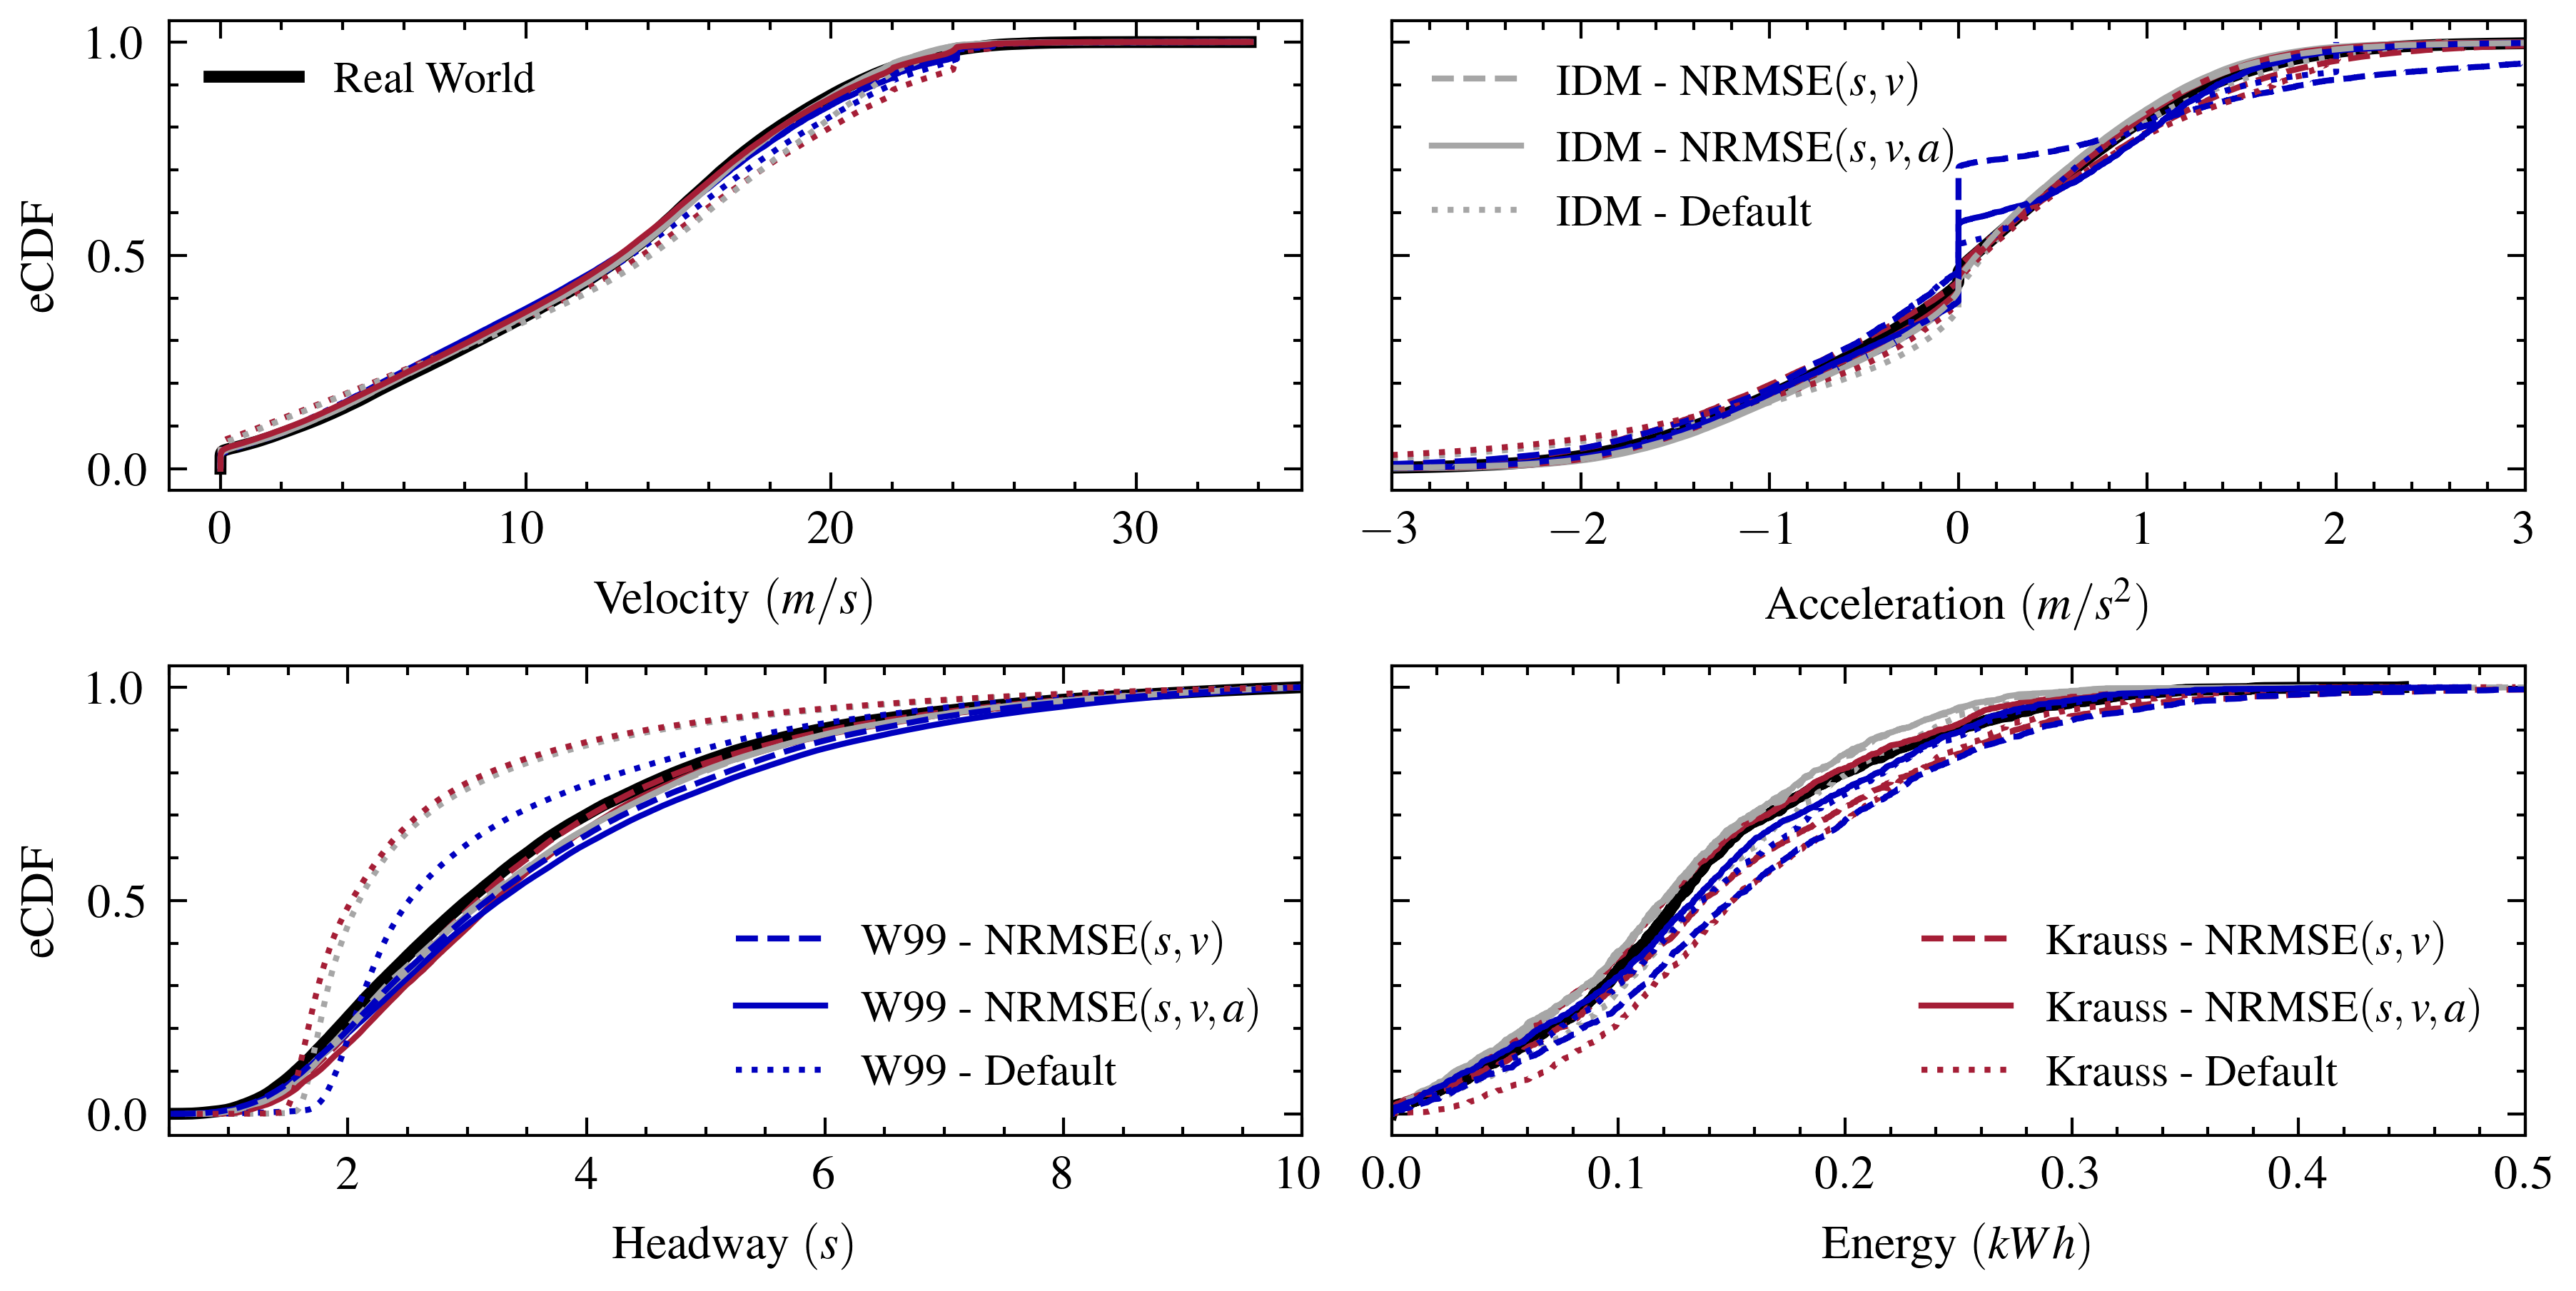

In [ ]:
# make a 2x2 grid of plots
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(6, 3), constrained_layout=True)

# plot the cdfs
plot_cdf(
    vel_df,
    ax[0, 0],
    "Velocity $(m/s)$",
)
# set the x-axis range
# ax[0, 0].set_xlim(0, 30)

plot_cdf(
    accel_df,
    ax[0, 1],
    "Acceleration $(m/s^2)$",
)
# set the x-axis range
ax[0, 1].set_xlim(-3, 3)

plot_cdf(
    # headway_df.filter(pl.col("value").is_between(0, 5)),
    headway_df.filter(
        pl.col("value").is_between(0, 10)
    ),
    ax[1, 0],
    "Headway $(s)$",
)
# set the x-axis range
ax[1, 0].set_xlim(0.5, 10)

# plot_cdf(
#     accel_df.filter(pl.col("value") <= 0),
#     ax[1, 1],
#     "Deceleration $(m/s^2)$",
# )
# # set the x-axis range
# ax[1, 1].set_xlim(-3, 0)

# plot the cdf of power

plot_cdf(energy_df, ax[1, 1], "Energy $(kWh)$")
ax[1, 1].set_xlim(0, 0.5)


# set the y labels
ax[0, 0].set_ylabel("eCDF", )
# reduce the text size of the y labels
ax[1, 0].set_ylabel("eCDF", )

# add legends
# ax[0, 0].legend(title="Model", loc="upper left")
# show just IDM on 0,0 legend, W99 on the 0,1 legend, Krauss on the 1,0 legend, and W99 on the 1,1 legend
# ax[0, 0].legend(title="", loc="upper left")


def fix_legend(keep_substring, ax):
    # for ax in ax.flatten():
    handles, labels = ax.get_legend_handles_labels()

    # # make a dummy handle for the Car Following Model
    # handles.extend(plt.plot(0, marker=None, linestyle=None, label=keep_substring))
    # labels.append(keep_substring)

    ax.legend(
        sorted(
            [h for h, l in zip(handles, labels) if keep_substring in l],
            key=lambda x: x.get_label(),
        ),
        sorted([l for l in labels if keep_substring in l], key=lambda x: x),
        title="",
        loc="best",
        prop={"size": 7.5},
    )


fix_legend("Real World", ax[0, 0])
fix_legend("IDM", ax[0, 1])
fix_legend("W99", ax[1, 0])
fix_legend("Krauss", ax[1, 1])

### Investigate Acceleration Distributions

In [ ]:
# best_traj.head()

/tmp/ipykernel_63545/1885834330.py:157: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


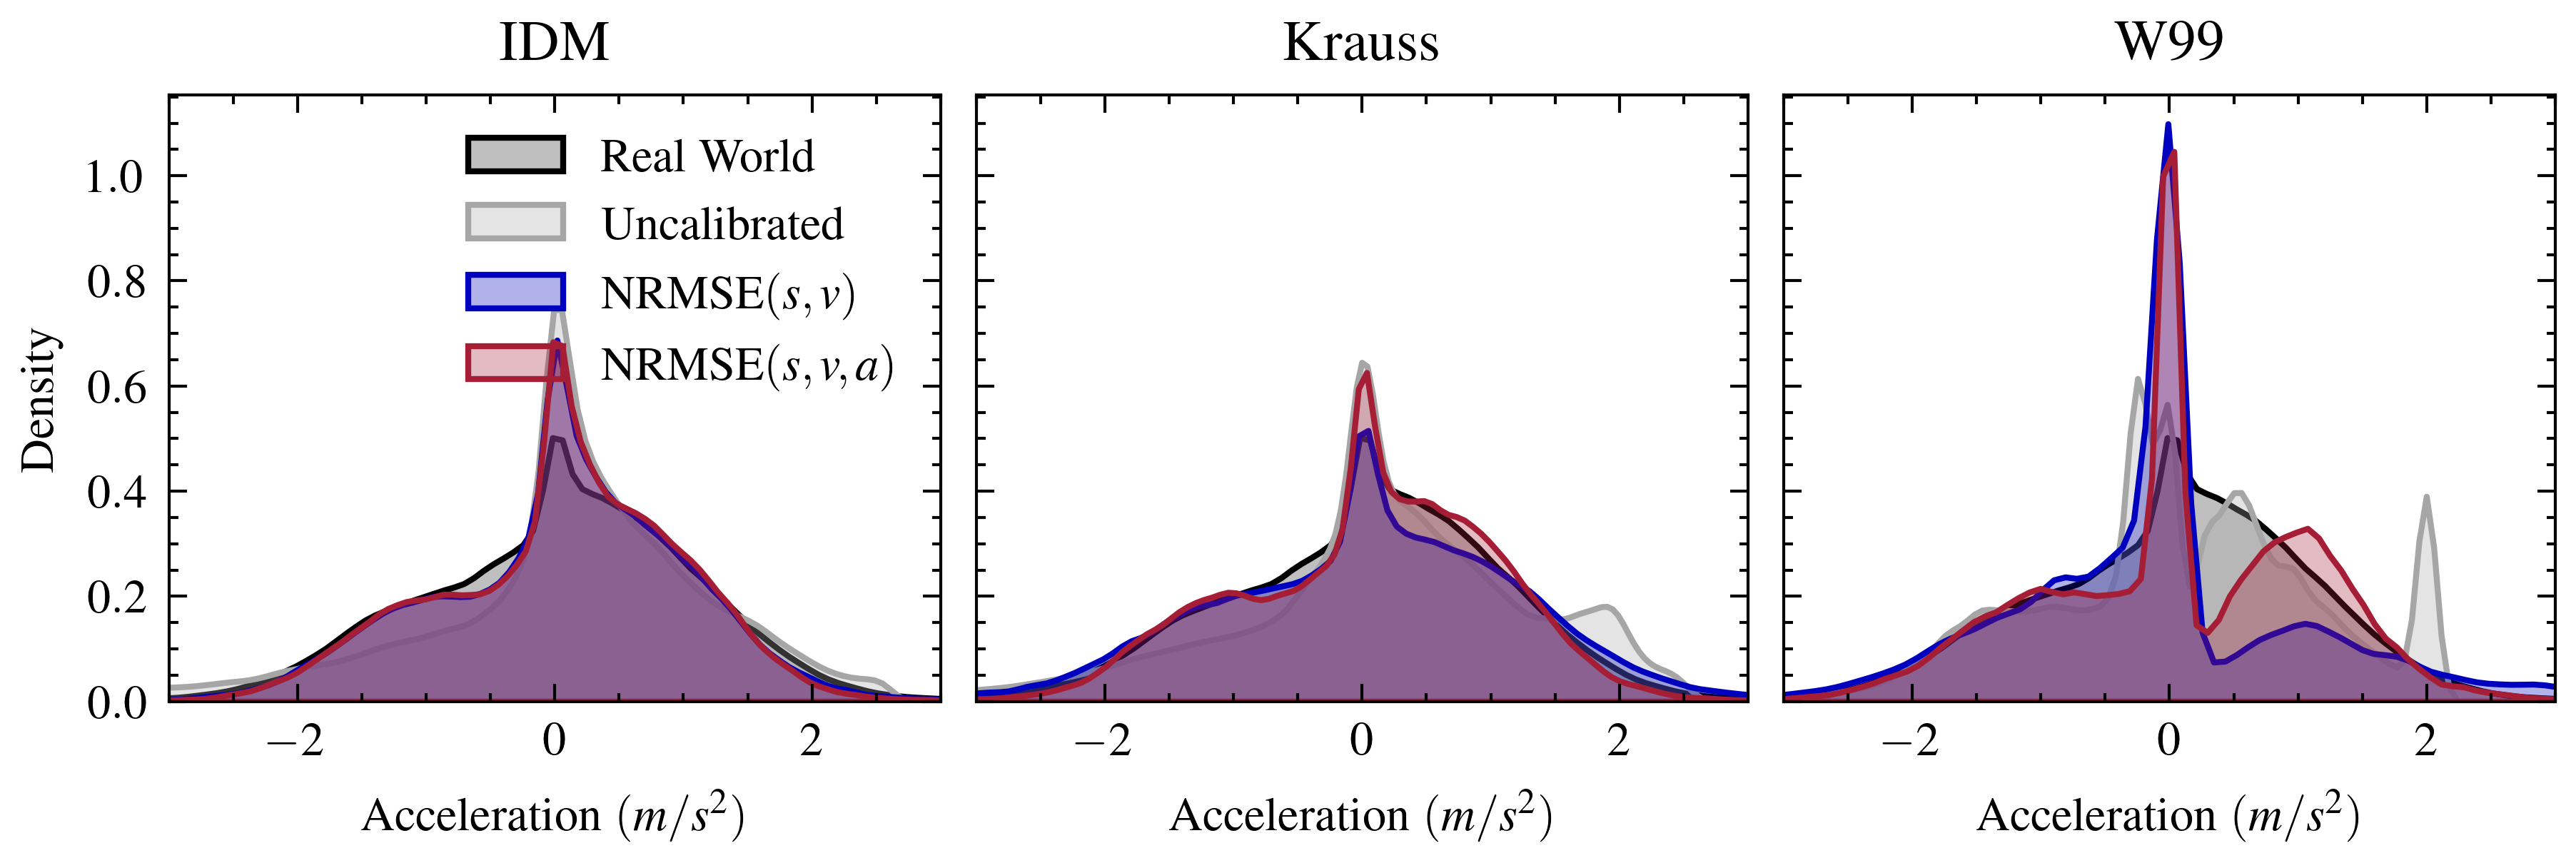

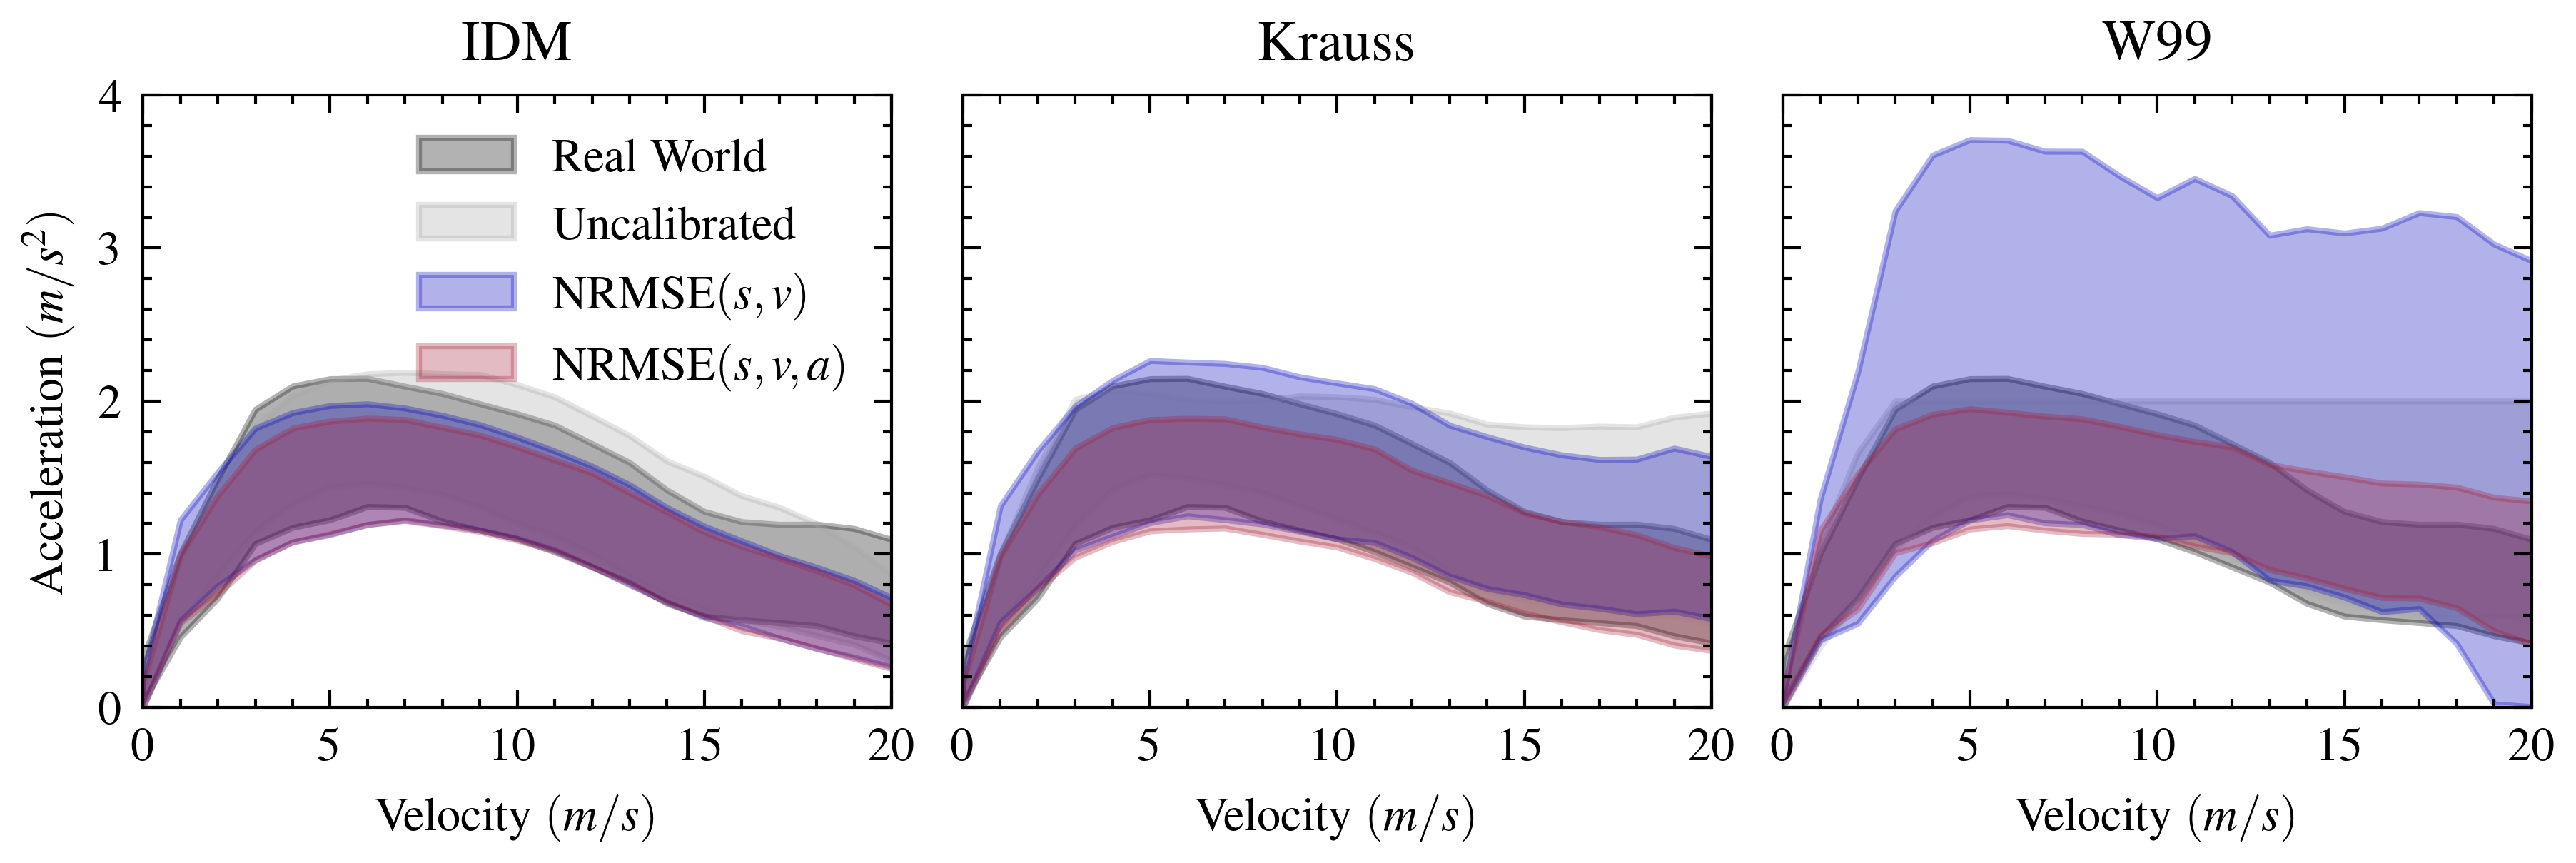

In [101]:
# plot a KDE of Acceleration for all three models

fig, ax = plt.subplots(1, 3, figsize=(6, 2), constrained_layout=True, sharey=True)

other_fig, ax_other = plt.subplots(
    1, 3, figsize=(6, 2), constrained_layout=True, sharey=True
)

for i, model in enumerate(["IDM", "Krauss", "W99"]):
    sns.kdeplot(
        best_traj.filter(
            (pl.col("model_pretty") == f"{model} - Default")
            & pl.col("accel_follow").is_between(-10, 10)
        )["accel_follow"],
        ax=ax[i],
        color="black",
        fill=True,
        label="Real World",
        # z=0
    )

    res = (
        best_traj.filter(
            (pl.col("model_pretty") == f"{model} - Default")
            & pl.col("accel_follow").is_between(0, 10)
        )
        .group_by(pl.col("velocity_follow").round(0).cast(int))
        .agg(
            pl.col("accel_follow").quantile(0.90).alias("q90"),
            pl.col("accel_follow").quantile(0.10).alias("q5"),
            pl.col("accel_follow").quantile(0.50).alias("q50"),
        )
        .sort("velocity_follow")
    )

    # # now do a plot of the velocity vs positive acceleration
    # ax_other[i].plot(
    #     res["velocity_follow"],
    #     res["q90"],
    #     # label="Median",
    #     label="Real World",
    #     # line_width=2,
    # )

    ax_other[i].fill_between(
        res["velocity_follow"],
        res["q50"],
        res["q90"],
        alpha=0.3,
        color="black",
        # label="IQR",
        label="Real World",
    )

    # for j, col in enumerate(["velocity_follow_sim_accel", "velocity_follow_accel"]):
    for k, model_pretty in enumerate(
        [
            f"{model} - Default",
            f"{model} - Calibrated",
            f"{model} - Calibrated - Accel",
        ]
    ):
        {
            "Default": "Uncalibrated",
            "Calibrated": "$\\text{NRMSE}(s, v)$",
            "Accel": "$\\text{NRMSE}(s, v, a)$",
        }

        # add a plot of the default
        sns.kdeplot(
            best_traj.filter(pl.col("model_pretty") == model_pretty)[
                "velocity_follow_sim_accel"
            ],
            ax=ax[i],
            color=[engine_color, gps_color, alabama][k],
            fill=True,
            alpha=0.3,
            # set the line to be solid
            linestyle="-",
            legend=True if i == 0 else False,
            label={
                "Default": "Uncalibrated",
                "Calibrated": "$\\text{NRMSE}(s, v)$",
                "Accel": "$\\text{NRMSE}(s, v, a)$",
            }[model_pretty.split(" - ")[-1]],
        )

        res = (
            best_traj.filter(
                (pl.col("model_pretty") == model_pretty)
                & pl.col("velocity_follow_sim_accel").is_between(0, 10)
            )
            .group_by(pl.col("velocity_follow_sim").round(0).cast(int))
            .agg(
                pl.col("velocity_follow_sim_accel").quantile(0.90).alias("q90"),
                # pl.col("velocity_follow_sim_accel").quantile(0.10).alias("q5"),
                pl.col("velocity_follow_sim_accel").quantile(0.50).alias("q50"),
            )
            .sort("velocity_follow_sim")
        )

        # now do a plot of the velocity vs positive acceleration
        # ax_other[i].plot(
        #     res["velocity_follow_sim"],
        #     res["q90"],
        #     label={
        #         "Default": "Uncalibrated",
        #         "Calibrated": "$\\text{NRMSE}(s, v)$",
        #         "Accel": "$\\text{NRMSE}(s, v, a)$",
        #     }[model_pretty.split(" - ")[-1]],
        #     color=[engine_color, gps_color, alabama][k],
        #     linestyle="-",
        # )

        ax_other[i].fill_between(
            res["velocity_follow_sim"],
            res["q50"],
            res["q90"],
            alpha=0.3,
            color=[engine_color, gps_color, alabama][k],
            label={
                "Default": "Uncalibrated",
                "Calibrated": "$\\text{NRMSE}(s, v)$",
                "Accel": "$\\text{NRMSE}(s, v, a)$",
            }[model_pretty.split(" - ")[-1]],
        )

        # ax.fill_between(
        #     res["velocity_follow_sim"],
        #     res["q_25"],
        #     res["q_75"],
        #     alpha=0.3,
        #     color=get_color(model_pretty),
        #     label="IQR",
        # )

    # turn the legend on
    if i == 0:
        ax[i].legend(title="", pos="best")
        ax_other[i].legend(title="")


    # set the axis bounds
    ax[i].set_xlim(-3, 3)
    ax_other[i].set_xlim(0, 20)
    ax_other[i].set_ylim(0, 4)

    ax[i].set_xlabel("Acceleration $(m/s^2)$")
    if i == 0:
        ax[i].set_ylabel("Density")
    ax[i].set_title(model)

    ax_other[i].set_xlabel("Velocity $(m/s)$")
    if i == 0:
        ax_other[i].set_ylabel("Acceleration $(m/s^2)$")
    ax_other[i].set_title(model)

fig.show()
# add a legend

In [ ]:
import pandas as pd
from scipy.stats import pearsonr, ks_2samp
from sklearn.metrics import r2_score, mean_squared_error

# create an empty dataframe
# calculate the correlation between the real and simulated energy
correlation_data = []
for m in best_traj["model_pretty"].unique():
    # if m == "Krauss - Default":
    #     continue

    real_df = (
        best_traj.filter((pl.col("model_pretty") == m))
        .filter(
            pl.col("accel_follow").is_between(0, 10)
            & pl.col("velocity_follow_sim_accel").is_between(0, 10)
        )
        .sort(["run_id", "time_sim"])
        # .with_columns(
        #     pl.col("accel_follow").shift(1).backward_fill(1).over(['run_id', ])
        # )
        .select("accel_follow")
        .to_pandas()["accel_follow"]
    )
    sim_df = (
        best_traj.filter((pl.col("model_pretty") == m))
        .filter(
            pl.col("accel_follow").is_between(0, 10)
            & pl.col("velocity_follow_sim_accel").is_between(0, 10)
        )
        .sort(["run_id", "time_sim"])
        .select("velocity_follow_sim_accel")
        .to_pandas()["velocity_follow_sim_accel"]
    )

    # calculate the R2 score
    r2 = r2_score(real_df, sim_df)

    # calculate the Pearson correlation coefficient
    pearson_r = pearsonr(real_df, sim_df)

    mse = mean_squared_error(real_df, sim_df)

    ks = ks_2samp(real_df, sim_df)

    # add the results to the dataframe
    # df = df.append({'Model': m, 'R2 Score': r2, 'Pearson R': pearson_r, }, ignore_index=True)

    correlation_data.append(
        {
            "Model": m,
            "Pearson r": pearson_r[0],
            "Pearson_r_p": pearson_r[1],
            "R-squared": r2,
            "RMSE": np.sqrt(mse),
            "ks": ks[0],
            "p-value": ks[1],
            "count": len(real_df),
        }
    )

correlation_df = pd.DataFrame(correlation_data).round(4)
correlation_df.sort_values("ks")

### Investigate the Headway Error

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), constrained_layout=True)


for model_pretty in best_traj["model_pretty"].unique():
    if "default" not in model_pretty.lower():
        continue

    res = (
        best_traj.filter(
            (pl.col("model_pretty") == model_pretty)
            & pl.col("spacing_sim").is_between(0, 1000)
            & pl.col("headway_real").is_between(0, 1000)
        )
        .with_columns(
            (pl.col("spacing_real") - pl.col("spacing_sim")).alias("spacing_error"),
            pl.col("velocity_follow_sim").cast(int),
        )
        .group_by("velocity_follow_sim")
        .agg(
            pl.col("spacing_error").median().alias("q_50"),
            pl.col("spacing_error").quantile(0.25).alias("q_25"),
            pl.col("spacing_error").quantile(0.75).alias("q_75"),
        )[["velocity_follow_sim", "q_50", "q_25", "q_75"]]
        .to_pandas()
        .sort_values("velocity_follow_sim")
    )

    ax.plot(
        res["velocity_follow_sim"],
        res["q_50"],
        label="Median",
        color=get_color(model_pretty),
    )
    ax.fill_between(
        res["velocity_follow_sim"],
        res["q_25"],
        res["q_75"],
        alpha=0.3,
        color=get_color(model_pretty),
        label="IQR",
    )

ax.set_xlabel("Velocity $(m/s)$")
ax.set_ylabel("Spacing Error $(m)$")

# ax.set_title(model_pretty)

# res = best_traj.filter(
#     (pl.col("model_pretty") == "Krauss - Default")
#     & pl.col("spacing_sim").is_between(0, 1000)
#     & pl.col("headway_real").is_between(0, 1000)
# ).with_columns(
#     (pl.col('spacing_real') - pl.col('spacing_sim')).alias('spacing_error'),
#     pl.col('velocity_follow_sim').cast(int)
# ).group_by('velocity_follow_sim').agg(
#     pl.col('spacing_error').median().alias("q_50"),
#     pl.col('spacing_error').quantile(0.25).alias("q_25"),
#     pl.col('spacing_error').quantile(0.75).alias("q_75"),
# )[['velocity_follow_sim', 'q_50', 'q_25', 'q_75']].to_pandas().sort_values('velocity_follow_sim')

# # plot the spacing error as a function of velocity
# fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), constrained_layout=True)

# ax.plot(res['velocity_follow_sim'], res['q_50'], label="Median", color=alabama)
# ax.fill_between(res['velocity_follow_sim'], res['q_25'], res['q_75'], alpha=0.3, color=alabama, label="IQR")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), constrained_layout=True)


for model_pretty in best_traj["model_pretty"].unique():
    if "default" not in model_pretty.lower():
        continue

    res = (
        best_traj.filter(
            (pl.col("model_pretty") == model_pretty)
            # & pl.col("spacing_sim").is_between(0, 1000)
            & pl.col("headway_sim").is_between(0, 5)
        )
        .with_columns(
            (pl.col("spacing_real") - pl.col("spacing_sim")).alias("spacing_error"),
            pl.col("velocity_follow_sim").cast(int),
        )
        .group_by("velocity_follow_sim")
        .agg(
            pl.col("headway_sim").median().alias("q_50"),
            pl.col("headway_sim").quantile(0.25).alias("q_25"),
            pl.col("headway_sim").quantile(0.75).alias("q_75"),
        )[["velocity_follow_sim", "q_50", "q_25", "q_75"]]
        .to_pandas()
        .sort_values("velocity_follow_sim")
    )

    ax.plot(
        res["velocity_follow_sim"],
        res["q_50"],
        label="Median",
        color=get_color(model_pretty),
    )
    ax.fill_between(
        res["velocity_follow_sim"],
        res["q_25"],
        res["q_75"],
        alpha=0.3,
        color=get_color(model_pretty),
        label="IQR",
    )


xy = (
    best_traj.filter(
        (pl.col("model_pretty") == "Krauss - Default")
        & pl.col("headway_real").is_between(0, 5)
    )
    .select(
        [
            "velocity_follow",
            "headway_real",
        ]
    )
    .group_by([pl.col("velocity_follow").cast(int)])
    .agg(pl.col("headway_real").mean())
    .sort("velocity_follow")
    .to_numpy()
)


# plot the spacing error as a function of velocity
ax.plot(
    xy[:, 0],
    xy[:, 1],
    label="Real World",
    color="black",
    linestyle="-",
)

ax.set_xlabel("Velocity $(m/s)$")
ax.set_ylabel("Spacing Error $(m)$")

# set the x-range
ax.set_xlim(0, 25)


# # plot the spacing error as a function of velocity
# fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), constrained_layout=True)

# ax.plot(res['velocity_follow_sim'], res['q_50'], label="Median", color=alabama)
# ax.fill_between(res['velocity_follow_sim'], res['q_25'], res['q_75'], alpha=0.3, color=alabama, label="IQR")

In [ ]:
xy = (
    best_traj.filter(
        (pl.col("model_pretty") == "Krauss - Default")
        # & pl.col("spacing_sim").is_between(0, 1000)
        & pl.col("headway_real").is_between(0, 5)
    )
    .select(
        [
            "velocity_follow",
            "headway_real",
        ]
    )
    .group_by([pl.col("velocity_follow").cast(int)])
    .agg(pl.col("headway_real").mean())
    .to_numpy()
)

# scatter plot the headway and velocity
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), constrained_layout=True)

ax.scatter(xy[:, 0], xy[:, 1], alpha=1, s=1)

# set the y-range
# ax.set_ylim(0, 10)

In [ ]:
# calculate the IQR of headway for each model
headway_df.filter(pl.col("value").is_between(0.5, 10)).to_pandas().groupby(
    "model_pretty"
)["value"].describe().assign(iqr=lambda df: df["75%"] - df["25%"]).sort_values(
    "50%"
).round(2)

In [ ]:
np.percentile(headway_df["value"], q=range(0, 100, 1))

In [ ]:
import numpy as np

qq_df = (
    headway_df.filter(~pl.col("model_pretty").str.contains("Default"))
    .group_by("model_pretty")
    .agg(
        pl.col("value").map_elements(
            lambda x: pl.Series(np.percentile(x, q=range(0, 100, 1)))
        )
    )
    .explode("value")
    .sort("value")
)

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), constrained_layout=True)

for model in qq_df["model_pretty"].unique():
    ax.plot(
        qq_df.filter(pl.col("model_pretty") == "Real World").to_pandas()["value"],
        qq_df.filter(pl.col("model_pretty") == model).to_pandas()["value"],
        label=model,
    )

# add a 45 degree line
ax.plot([0, 10], [0, 10], linestyle="--", color="red")

# set the axis labels
ax.set_xlabel("Measured Headway Quantiles")
ax.set_ylabel("Simulated Headway Quantiles")

# set the actual x-ticks to be quantiles
# ax.set_xticks(range(0, 100, 10))
# ax.set_xticklabels([f"{i}%" for i in range(0, 100, 10)])

# # set the actual y-ticks to be quantiles
# # ax.set_yticks(range(0, 100, 10))
# ax.set_yticklabels([f"{i}%" for i in range(0, 100, 10)])

# turn on the legend
ax.legend(title="Model")

In [ ]:
# # calculate the IQR of headway for each model
# headway_df.filter(pl.col("value").is_between(0, 5)).to_pandas().groupby("model_pretty")[
#     "value"
# ].describe().assign(iqr=lambda df: df["75%"] - df["25%"]).sort_values("50%")

In [ ]:
import pandas as pd
from scipy.stats import pearsonr, ks_2samp
from sklearn.metrics import r2_score, mean_squared_error

# create an empty dataframe
# calculate the correlation between the real and simulated energy

new_headway_df = best_traj.filter(
    pl.col("headway_real").is_between(0, 10)
    & (pl.col("headway_sim") < 100)
    & pl.col("headway_real").is_not_nan()
).pipe(
    build_stacked_df,
    rw_value_col="headway_real",
    sim_value_col="headway_sim",
)

correlation_data = []
for m in best_traj["model_pretty"].unique():
    # if m == "Krauss - Default":
    #     continue

    real_df = (
        best_traj.filter((pl.col("model_pretty") == m))
        .filter(
            pl.col("headway_real").is_between(0.5, 10)
            & pl.col("headway_sim").is_between(0.5, 10)
            # & pl.col("headway_real").is_not_nan()
        )
        .sort(["run_id", "time_sim"])
        .select("headway_real")
        .to_pandas()["headway_real"]
    )
    sim_df = (
        best_traj.filter((pl.col("model_pretty") == m))
        .filter(
            pl.col("headway_real").is_between(0.5, 10)
            & pl.col("headway_sim").is_between(0.5, 10)
            # & (pl.col("headway_sim") < 100)
            # & pl.col("headway_real").is_not_nan()
        )
        .sort(["run_id", "time_sim"])
        .select(["headway_sim"])
        .to_pandas()["headway_sim"]
    )

    # calculate the R2 score
    r2 = r2_score(real_df, sim_df)

    # calculate the Pearson correlation coefficient
    pearson_r = pearsonr(real_df, sim_df)

    mse = mean_squared_error(real_df, sim_df)

    ks = ks_2samp(real_df, sim_df)

    # add the results to the dataframe
    # df = df.append({'Model': m, 'R2 Score': r2, 'Pearson R': pearson_r, }, ignore_index=True)

    correlation_data.append(
        {
            "Model": m,
            "Pearson r": pearson_r[0],
            "Pearson_r_p": pearson_r[1],
            "R-squared": r2,
            "RMSE": np.sqrt(mse),
            "ks": ks[0],
            "p-value": ks[1],
            "count": len(real_df),
        }
    )

correlation_df = pd.DataFrame(correlation_data).round(4)
correlation_df.sort_values("ks")

In [ ]:
# Compare the Accel vs Non-Accel for All Models
from scipy.stats import mannwhitneyu

# create an empty dataframe

for model in ["W99", "IDM", "Krauss"]:
    real_df = (
        best_traj.filter((pl.col("model_pretty") == f"{model} - Calibrated"))
        .filter(
            pl.col("headway_real").is_between(0.5, 10)
            & pl.col("headway_sim").is_between(0.5, 10)
            # & pl.col("headway_real").is_not_nan()
        )
        .sort(["run_id", "time_sim"])
        .select("headway_real")
        .to_pandas()["headway_real"]
    )
    sim_df = (
        best_traj.filter((pl.col("model_pretty") == f"{model} - Calibrated - Accel"))
        .filter(
            pl.col("headway_real").is_between(0.5, 10)
            & pl.col("headway_sim").is_between(0.5, 10)
            # & (pl.col("headway_sim") < 100)
            # & pl.col("headway_real").is_not_nan()
        )
        .sort(["run_id", "time_sim"])
        .select(["headway_sim"])
        .to_pandas()["headway_sim"]
    )

    print(model, mannwhitneyu(real_df, sim_df, alternative="less"))

In [ ]:
pearson_r

In [ ]:
ks_2samp(real_df, sim_df)

In [ ]:
(
    best_traj.filter((pl.col("model_pretty") == m)).filter(
        # pl.col("headway_real").is_between(0, 10)
        # & (pl.col("headway_sim") < 100)
        # & pl.col("headway_real").is_not_nan()
    )
)

In [ ]:
sim_df

In [ ]:
m

In [ ]:
sim_df.shape

In [ ]:
real_df.shape